# Feature skew: [0.02, 0.1]
- initial analysis

### Conclusions:
1. No client thinks BatchSize=8 is good.
2. When looking in 2D (learning rate, momentum) good/best HPs are found (when neglecting BS)
3. Clients usually go for lower learning rate -> gt has larger learning rate.
4. 2D clustering gives better results for SVHN_cropped (not that better results for other datasets when using 3d clustering)
5. Selecting multiple best mean-acc clusters is not (always) needed -> usually the absolute best cluster is the one we need.

### GT Info

Best GT for all datasets/num clients/skew params:
<li>learning rate: 0.5 (±0)</li>
<li>momentum: 0.7125 (±0.015) --> either 0.6 or 0.9</li>
<li>batch size: 8 (±0)</li>


In [1]:
from clustering import get_gt_data
import pandas as pd
import glob

EXTENSION = ".csv"
DATA_FOLDER = "data"                                      # folder contains csv files for analyzing
DATASETS = glob.glob(DATA_FOLDER + f"/*{EXTENSION}")      # get all csv file names
DATASET_NAMES = [x[:-len(EXTENSION)] for x in DATASETS]   # remove extension from file names
DATASET_NAMES.sort()

df_best_hps = pd.DataFrame()
for name in DATASET_NAMES:
    gt = get_gt_data(name)                                # sorts by accuracy
    gt = gt[['server_lr', 'server_mom', 'batch_size']]
    df_best_hps = pd.concat([df_best_hps, gt.iloc[:1]])

df_best_hps.describe()


server_lr  server_mom  batch_size
count       16.0     16.0000        16.0
mean         0.5      0.7125         8.0
std          0.0      0.1500         0.0
min          0.5      0.6000         8.0
25%          0.5      0.6000         8.0
50%          0.5      0.6000         8.0
75%          0.5      0.9000         8.0
max          0.5      0.9000         8.0

### Clustering

In [3]:
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
from clustering import clustering, closest_gt_to_point, plot_points_agains_gt_2d, plot_points_agains_gt_3d
from scoring_funcs import scoring_function
from agg_funcs import average_params, average_params_weighted_acc

In [4]:
def derive_global_hp(clusterFn, clientData, dataset_name):
    ind_list = scoring_function(clientData, clusterFn, func_name="mean", shouldPrint=False, tolerance=0.02)[:3]

    derived_params = list()
    derived_params_pd = pd.DataFrame()

    for _, index in enumerate(ind_list):
        d_lr, d_mom, d_bs = average_params(index, clientData)
        (c_lr, c_mom, c_bs, c_acc), min_diff = closest_gt_to_point([d_lr, d_mom, d_bs], dataset_name)

        derived_params_pd = pd.concat([derived_params_pd, pd.DataFrame({'derived_lr': [d_lr], 'derived_mom': [d_mom], 'derived_bs': [d_bs]})])

        derived_params.append({
            "lr_mom_bs": (d_lr, d_mom, int(d_bs)),
            "closest_lr_mom_bs_acc": (c_lr, c_mom, c_bs, c_acc),
        })

    return derived_params, derived_params_pd

#### CIFAR-10

In [5]:
cifar_datasets = ['data/cifar10_feature_skew_0.02_10clients', 'data/cifar10_feature_skew_0.02_20clients',
                  'data/cifar10_feature_skew_0.1_10clients', 'data/cifar10_feature_skew_0.1_20clients',]

##### 0.02 skew

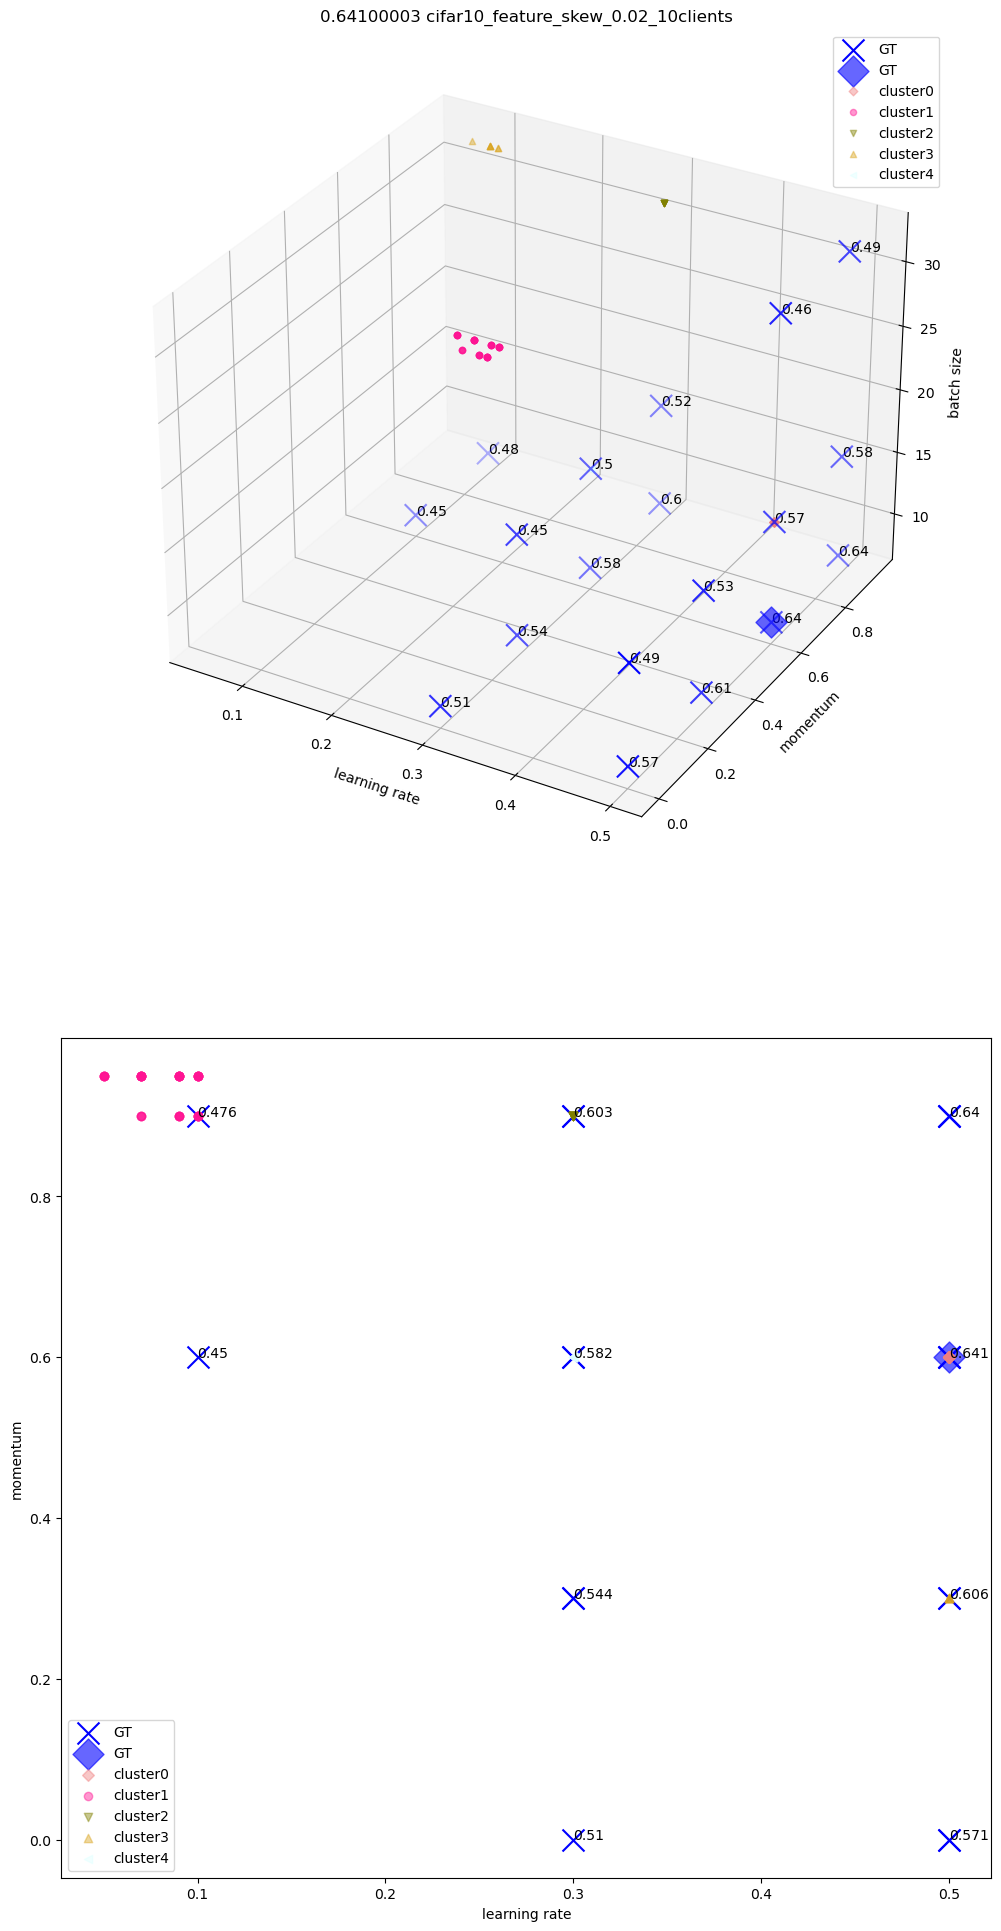

In [6]:
dataset_name = cifar_datasets[0]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

In 2d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.56670004)}, {'lr_mom_bs': (0.29999999999999993, 0.9000000000000002, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.43)}, {'lr_mom_bs': (0.08327586206896548, 0.9336206896551728, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.41680002)}]
In 3d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.56670004)}]


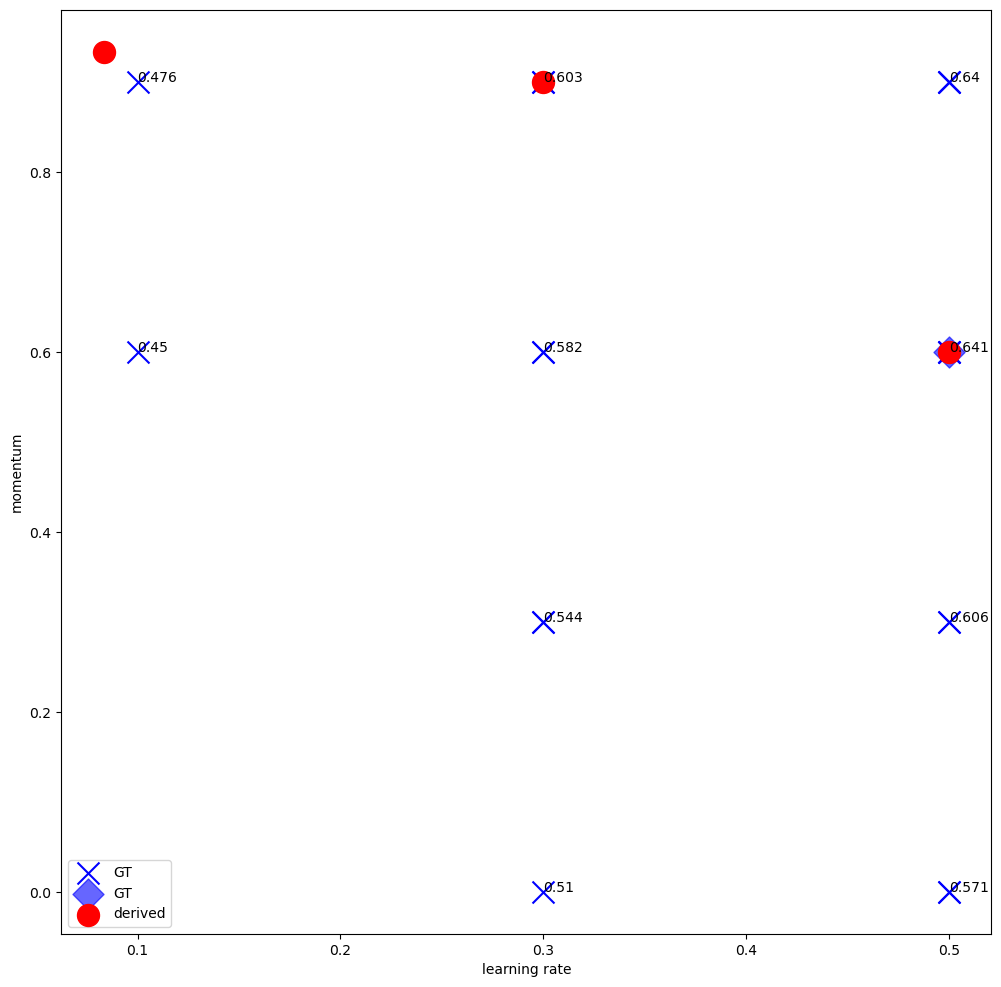

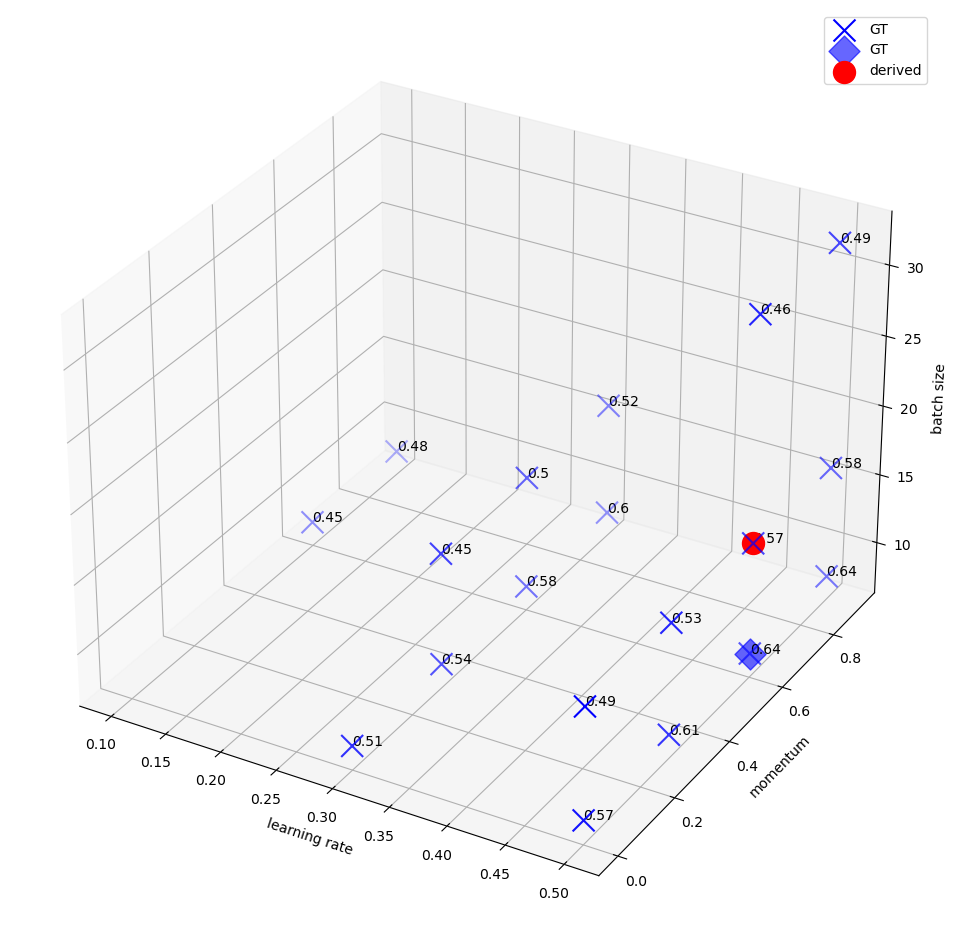

In [7]:
print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

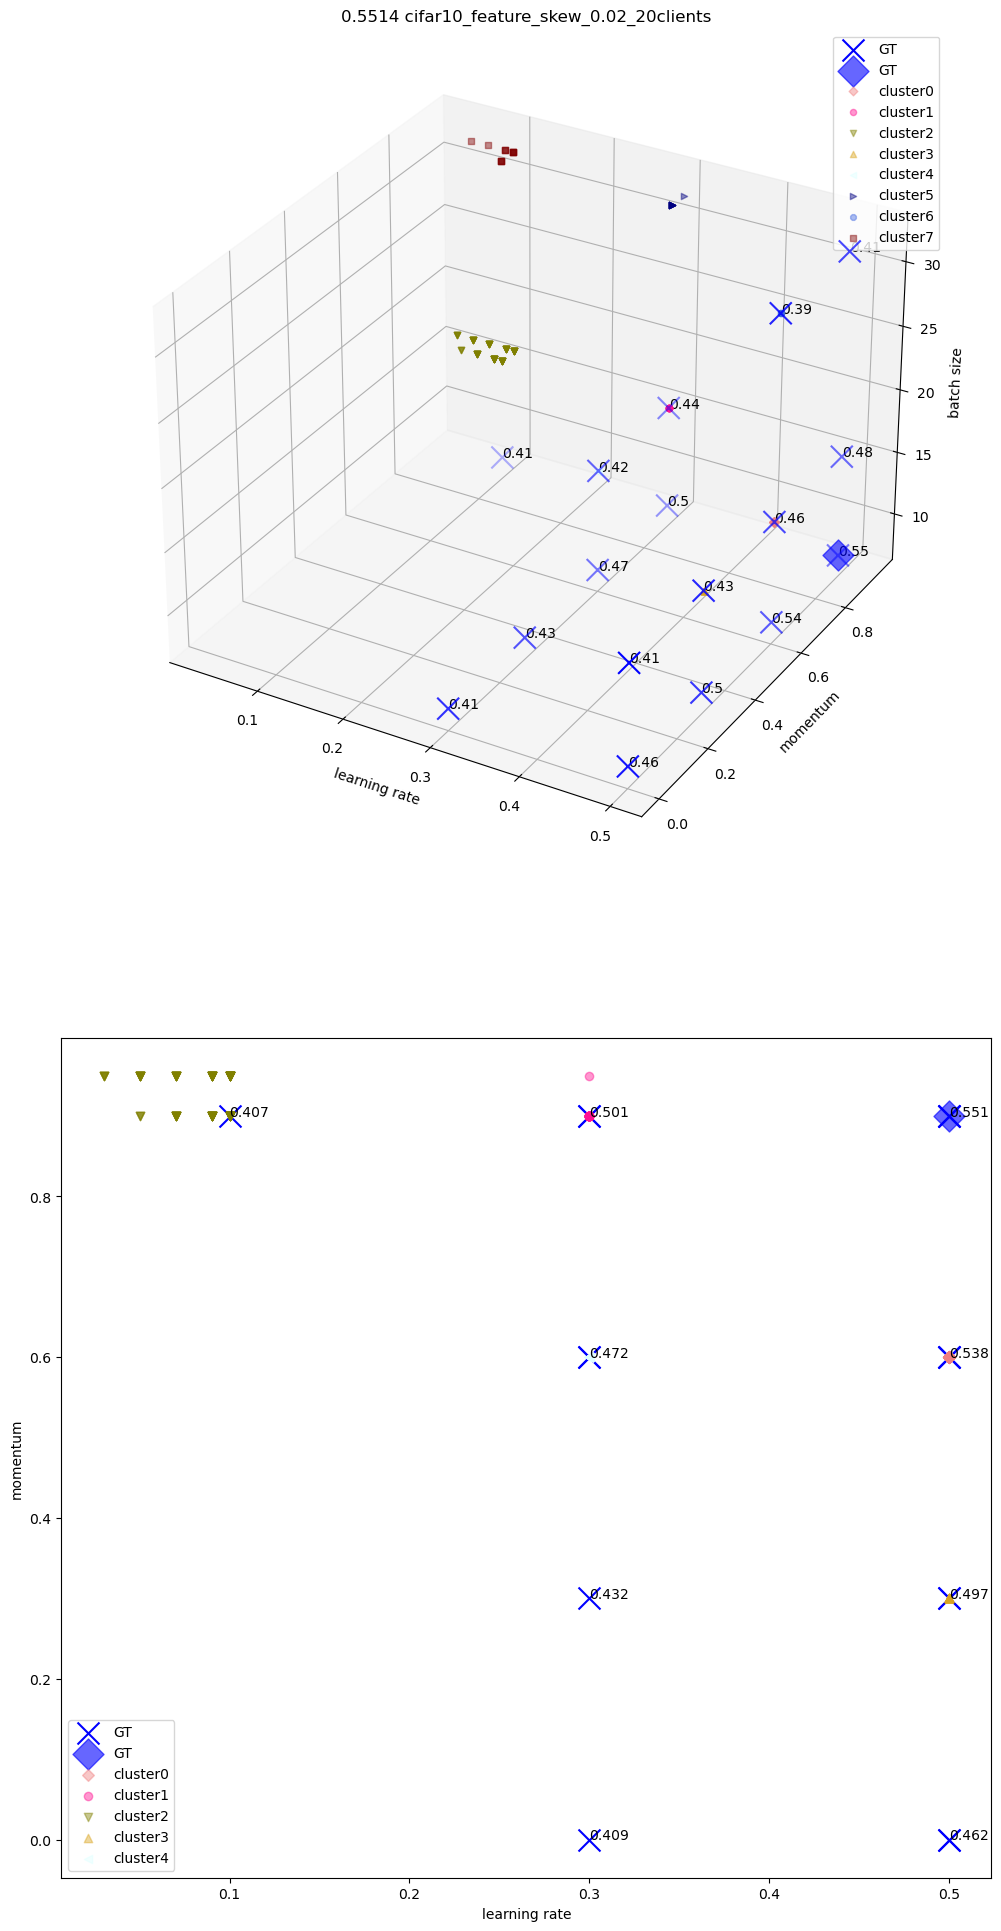

In [8]:
dataset_name = cifar_datasets[1]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

In 2d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.45650002)}, {'lr_mom_bs': (0.29999999999999993, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.3, 0.6, 16.0, 0.4158)}, {'lr_mom_bs': (0.2999999999999999, 0.9021739130434782, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.43510002)}]
In 3d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.45650002)}]


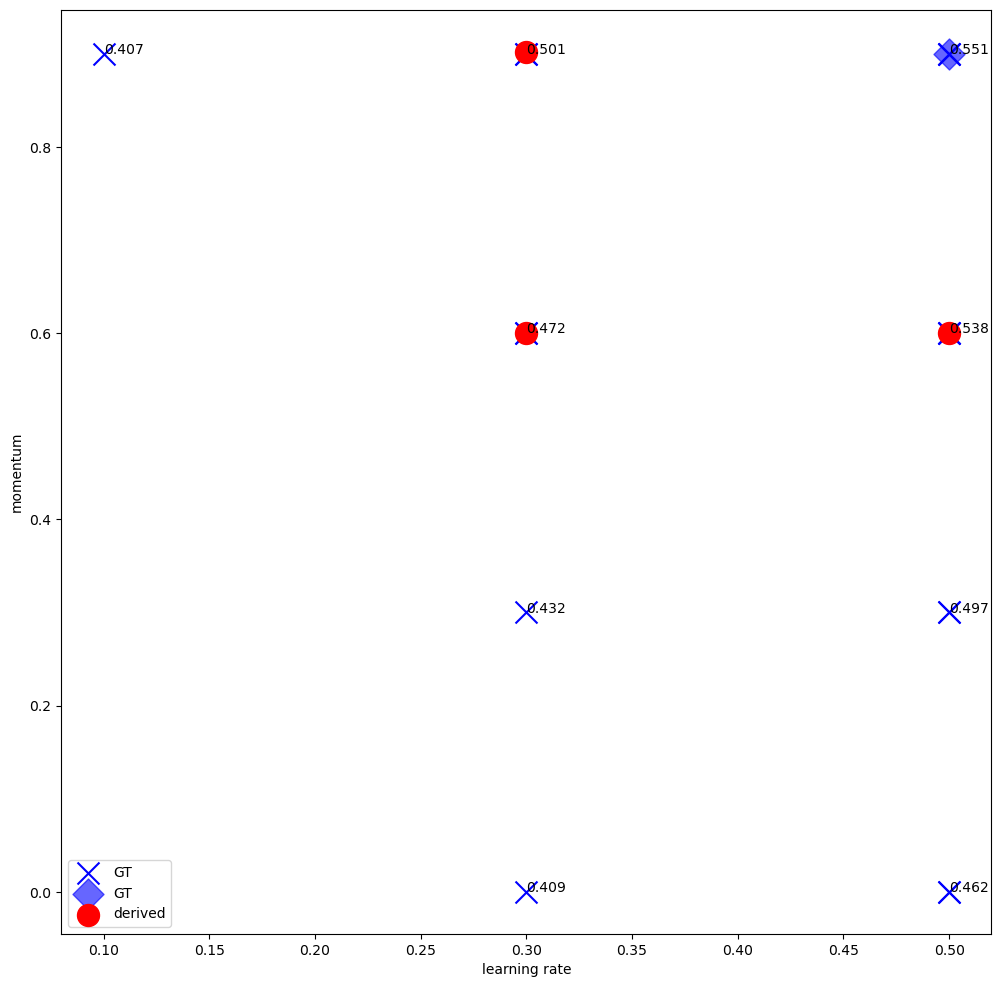

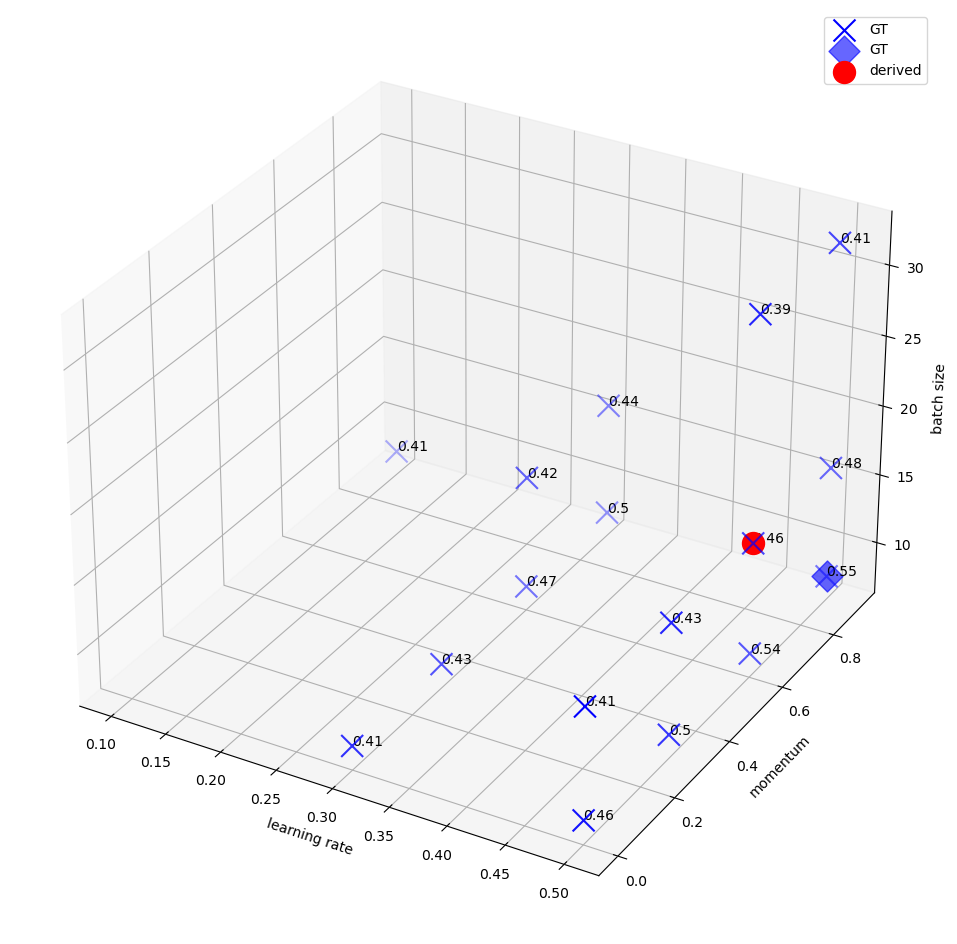

In [9]:
print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

##### 0.1 skew

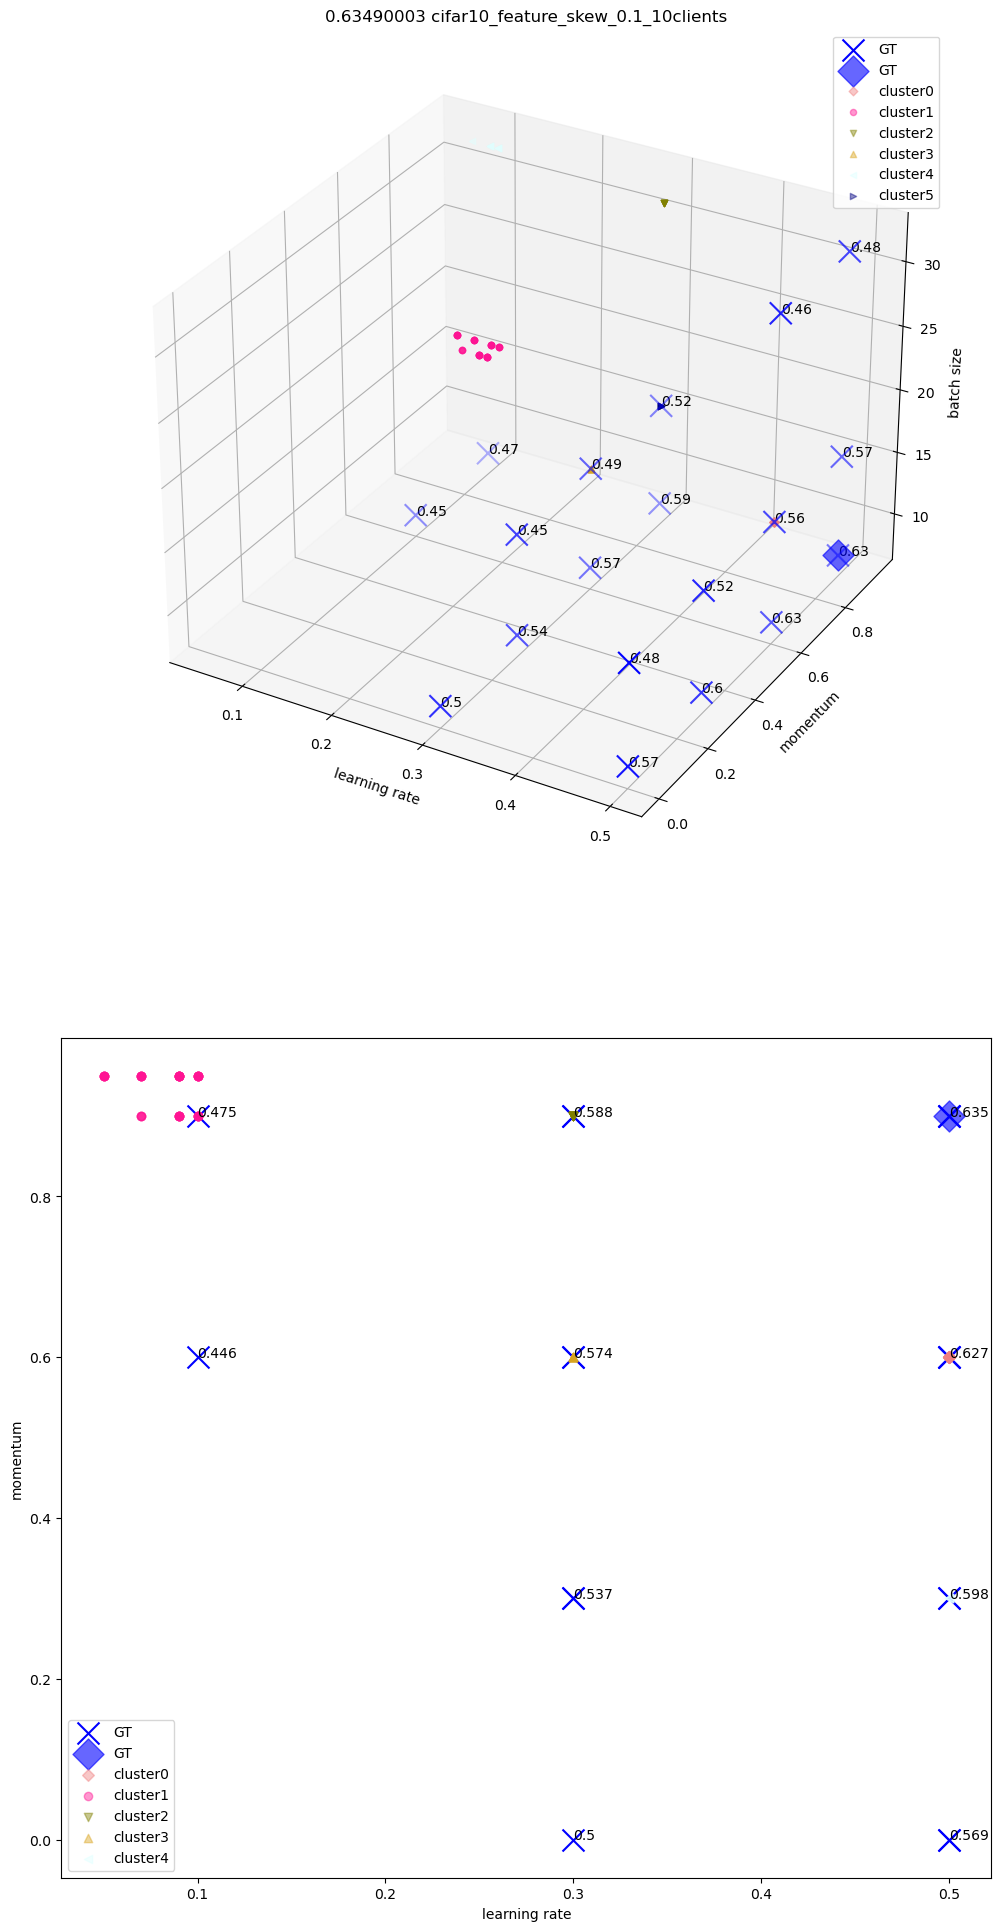

In [10]:
dataset_name = cifar_datasets[2]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

In 2d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.5589)}, {'lr_mom_bs': (0.29999999999999993, 0.9000000000000002, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.41860002)}, {'lr_mom_bs': (0.0838333333333333, 0.9316666666666669, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.4052)}]
In 3d: [{'lr_mom_bs': (0.5, 0.6, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.5589)}, {'lr_mom_bs': (0.3, 0.9000000000000001, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.41860002)}]


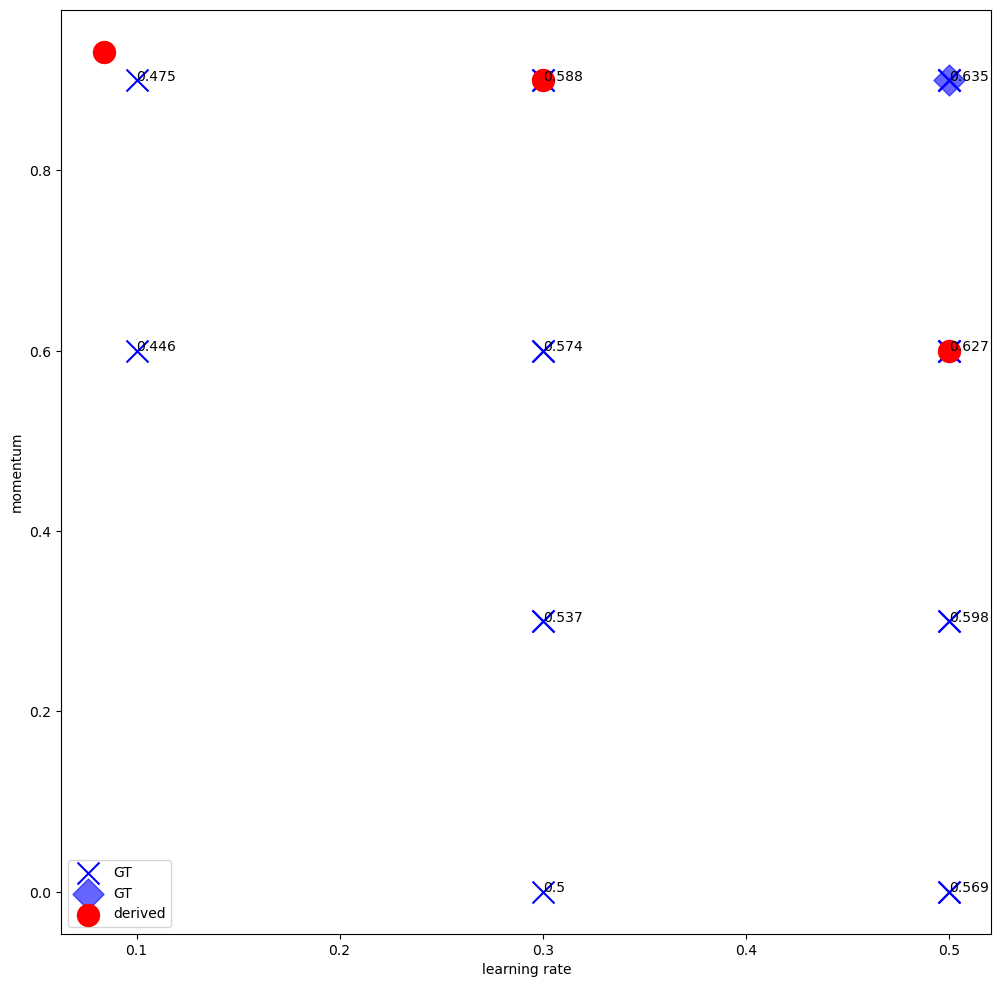

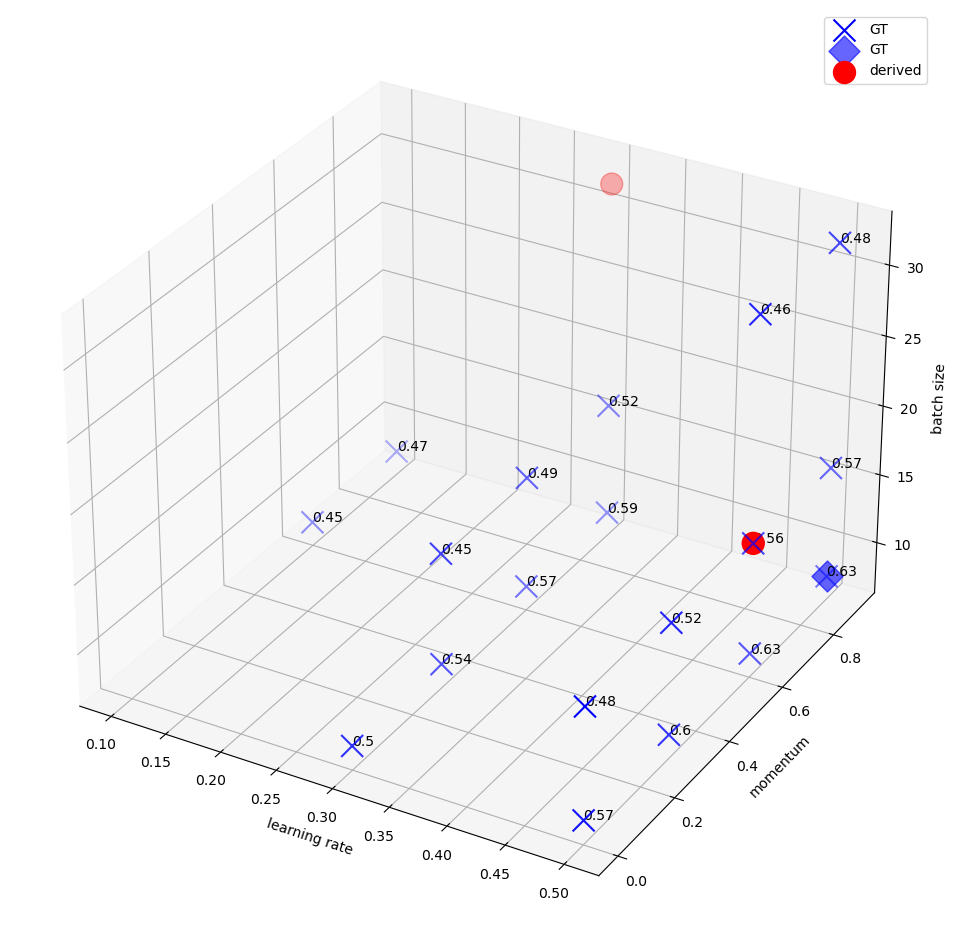

In [11]:
print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

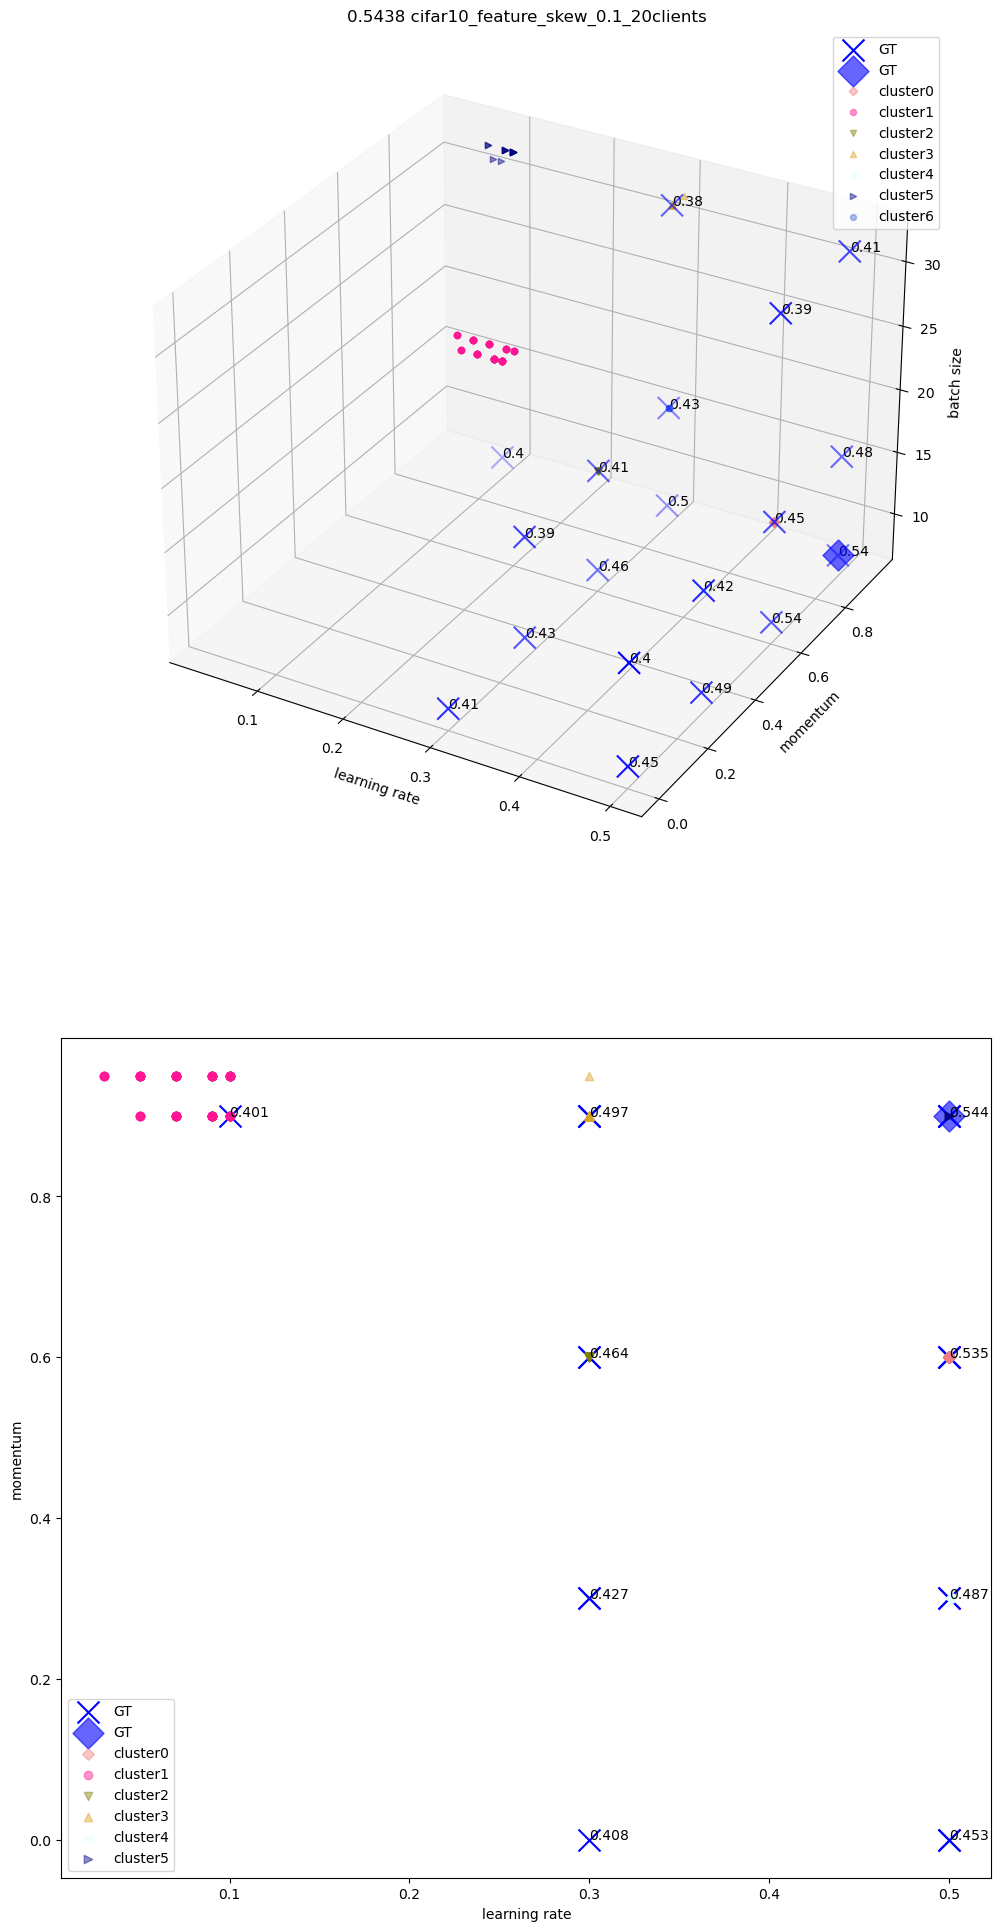

In [12]:
dataset_name = cifar_datasets[3]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

In 2d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.45190004)}, {'lr_mom_bs': (0.29999999999999993, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.3, 0.6, 16.0, 0.411)}, {'lr_mom_bs': (0.07924369747899157, 0.9256302521008422, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.35810003)}]
In 3d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.45190004)}, {'lr_mom_bs': (0.29999999999999993, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.3, 0.6, 16.0, 0.411)}, {'lr_mom_bs': (0.07730769230769227, 0.9230769230769246, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.35810003)}]


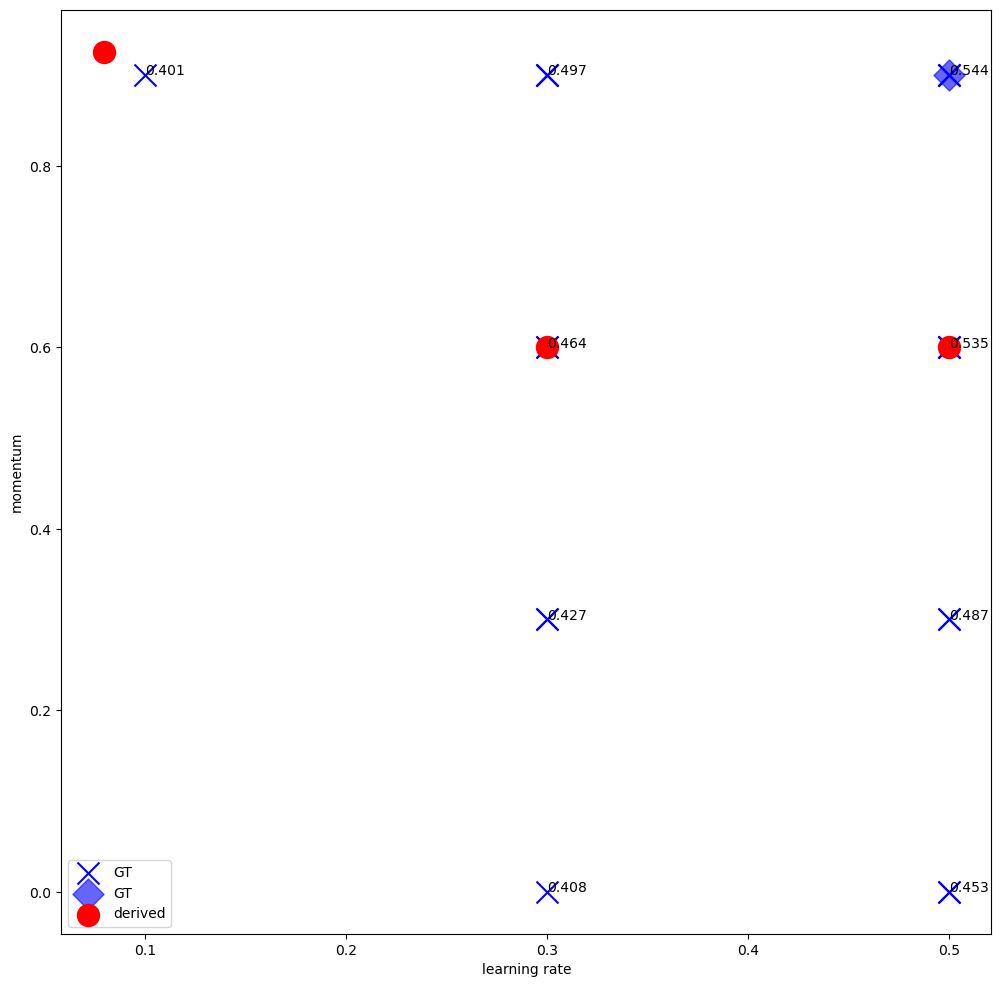

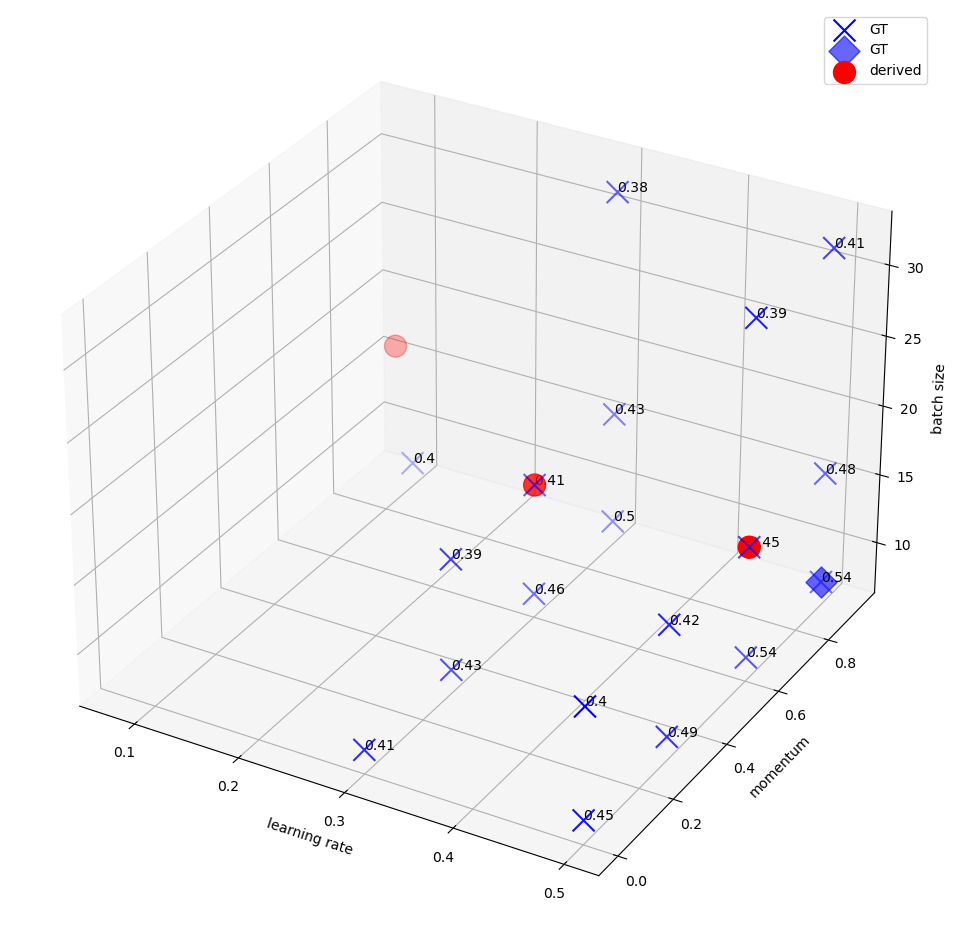

In [13]:
print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

#### MNIST

In [14]:
mnist_datasets = ['data/mnist_feature_skew_0.02_10clients', 'data/mnist_feature_skew_0.02_20clients',
 'data/mnist_feature_skew_0.1_10clients', 'data/mnist_feature_skew_0.1_20clients']

##### 0.02 skew

In 2d: [{'lr_mom_bs': (0.2999999999999999, 0.9211538461538459, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.9707)}, {'lr_mom_bs': (0.5, 0.9113636363636363, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.97310007)}, {'lr_mom_bs': (0.5, 0.6, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.98450005)}]
In 3d: [{'lr_mom_bs': (0.5, 0.9000000000000001, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.9858)}, {'lr_mom_bs': (0.29999999999999993, 0.9266666666666665, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.9707)}, {'lr_mom_bs': (0.29999999999999993, 0.9136363636363637, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.9825001)}]


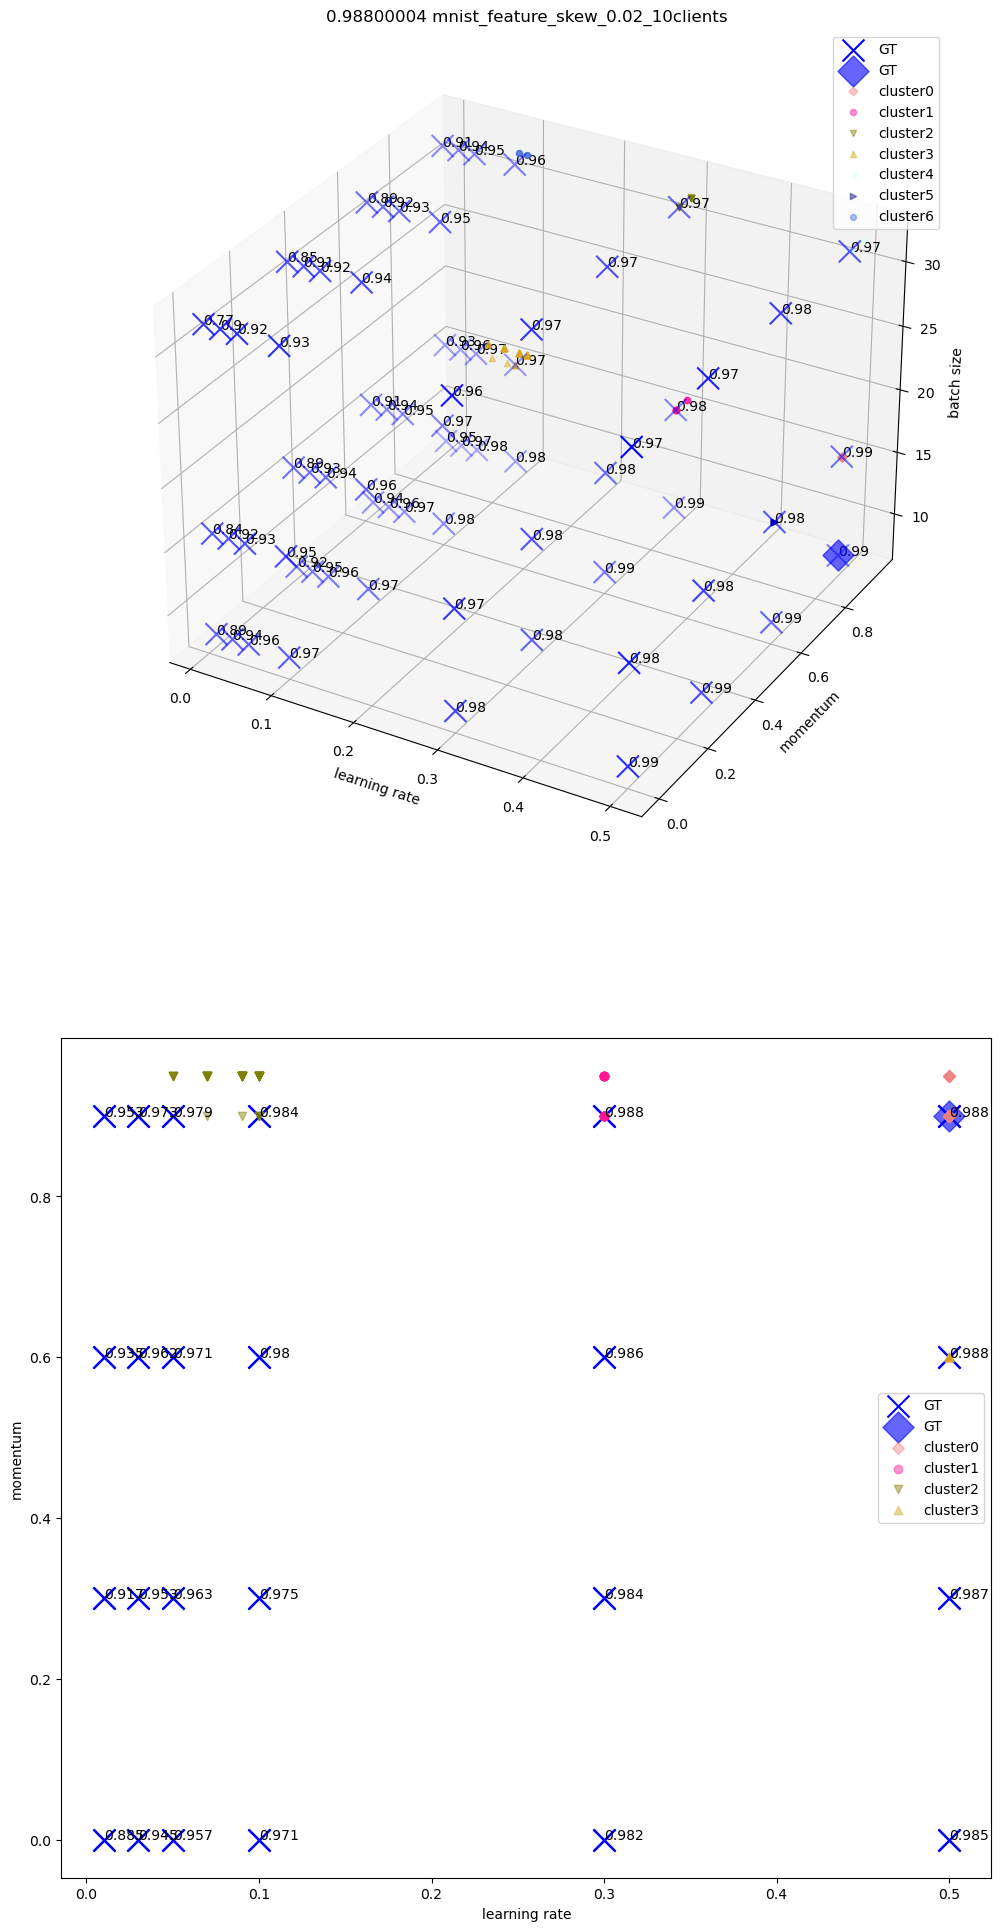

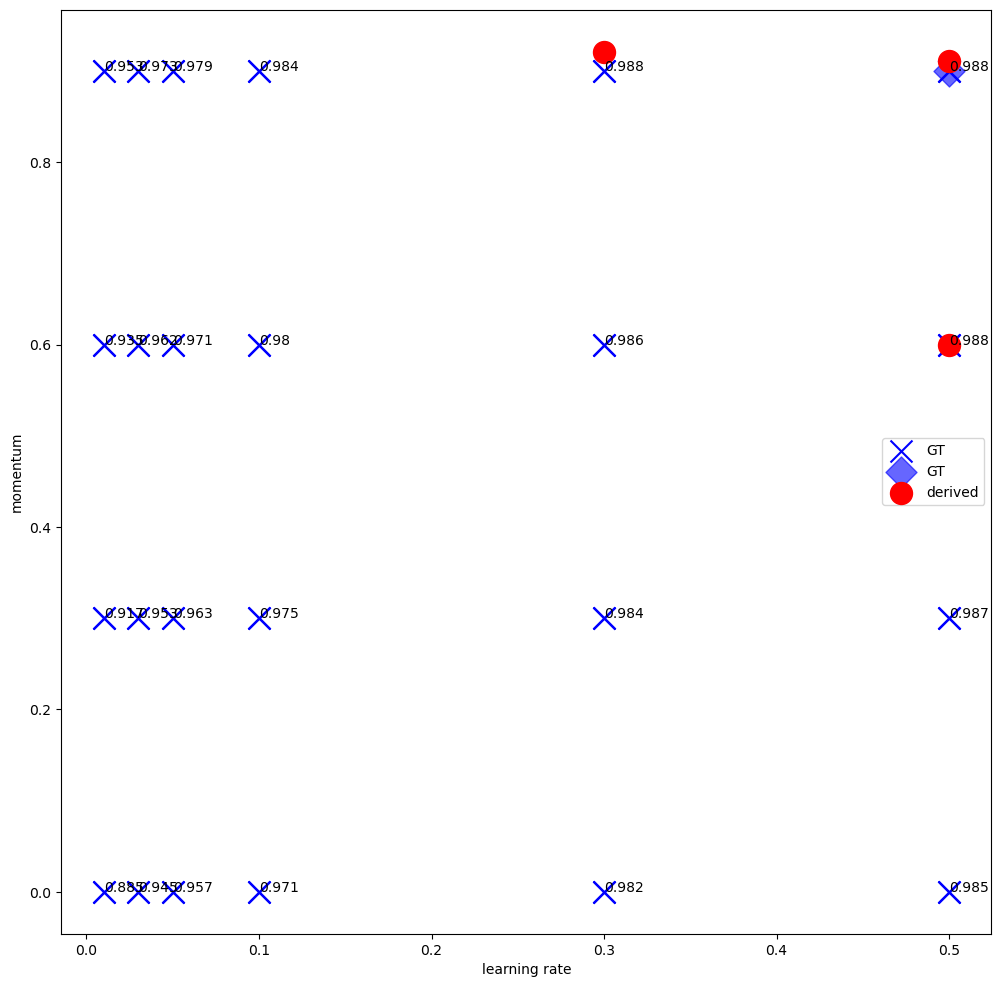

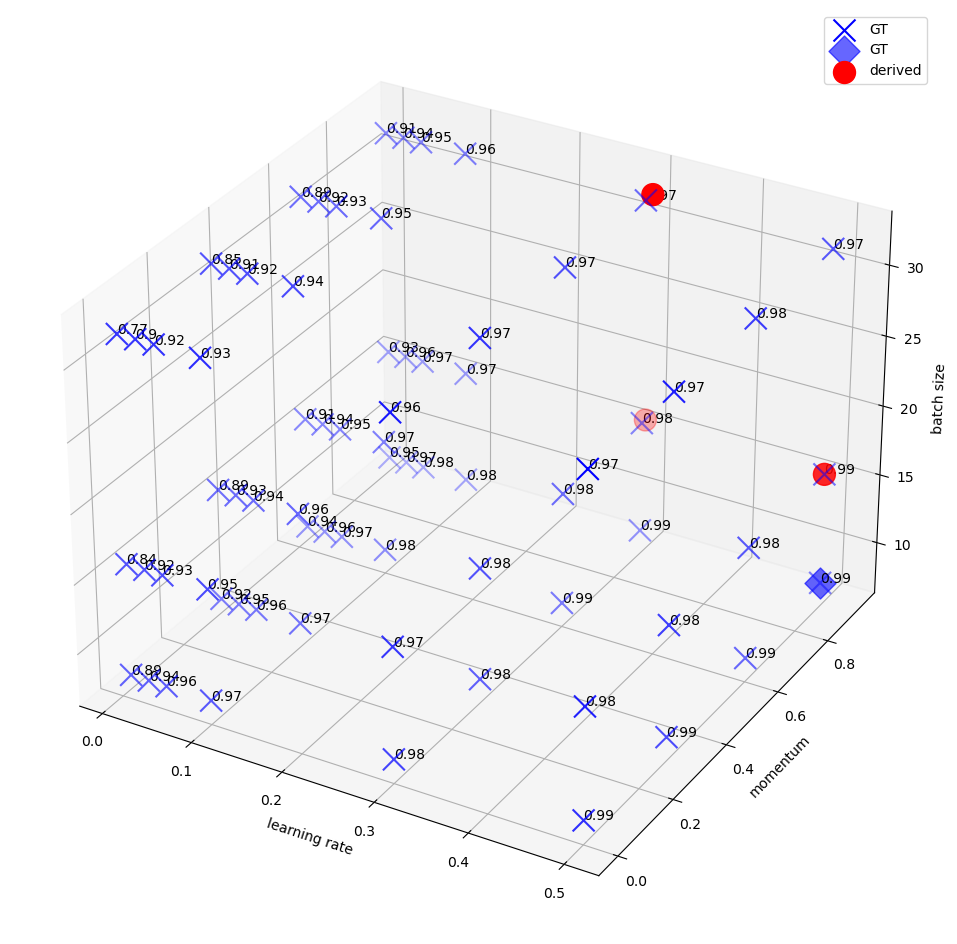

In [15]:
dataset_name = mnist_datasets[0]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

In 2d: [{'lr_mom_bs': (0.5, 0.9148936170212763, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.95690006)}, {'lr_mom_bs': (0.3000000000000004, 0.9253731343283583, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.97480005)}, {'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.98030007)}]
In 3d: [{'lr_mom_bs': (0.5, 0.9, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.9793)}, {'lr_mom_bs': (0.3000000000000001, 0.9242857142857137, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.97480005)}, {'lr_mom_bs': (0.5, 0.9249999999999996, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.95690006)}]


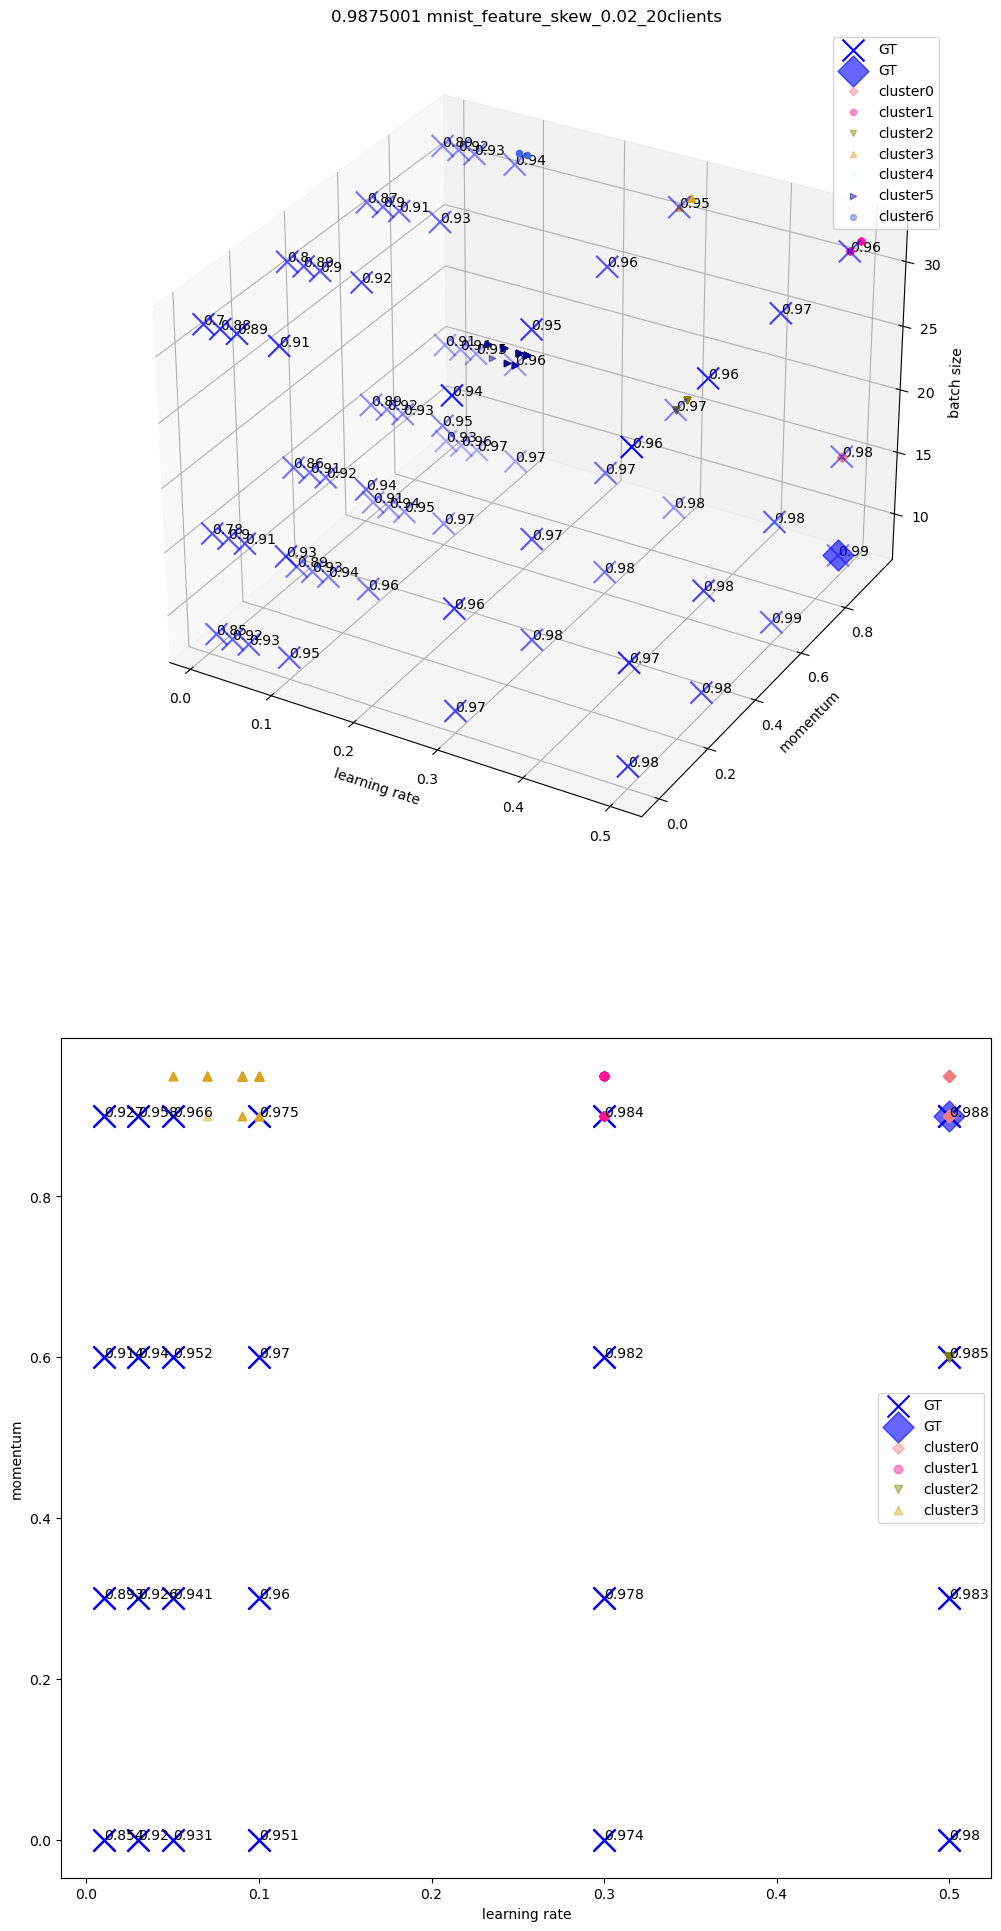

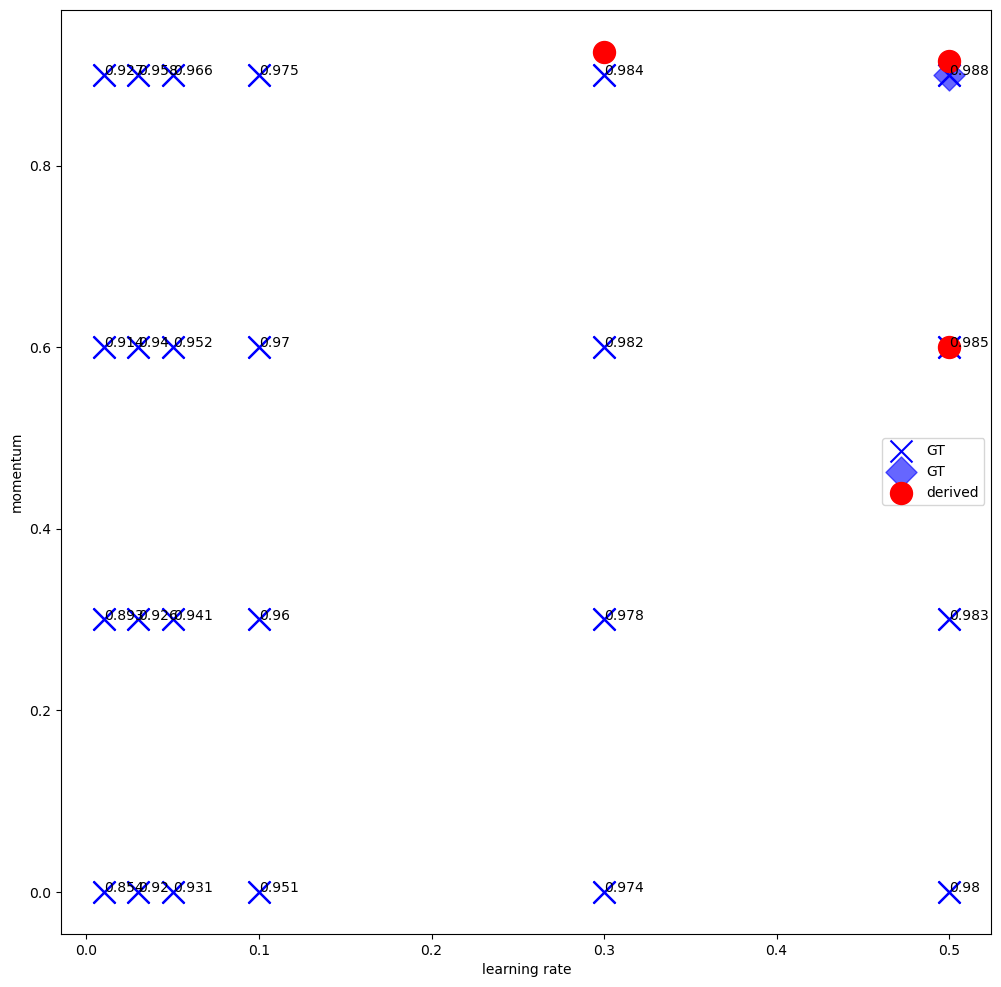

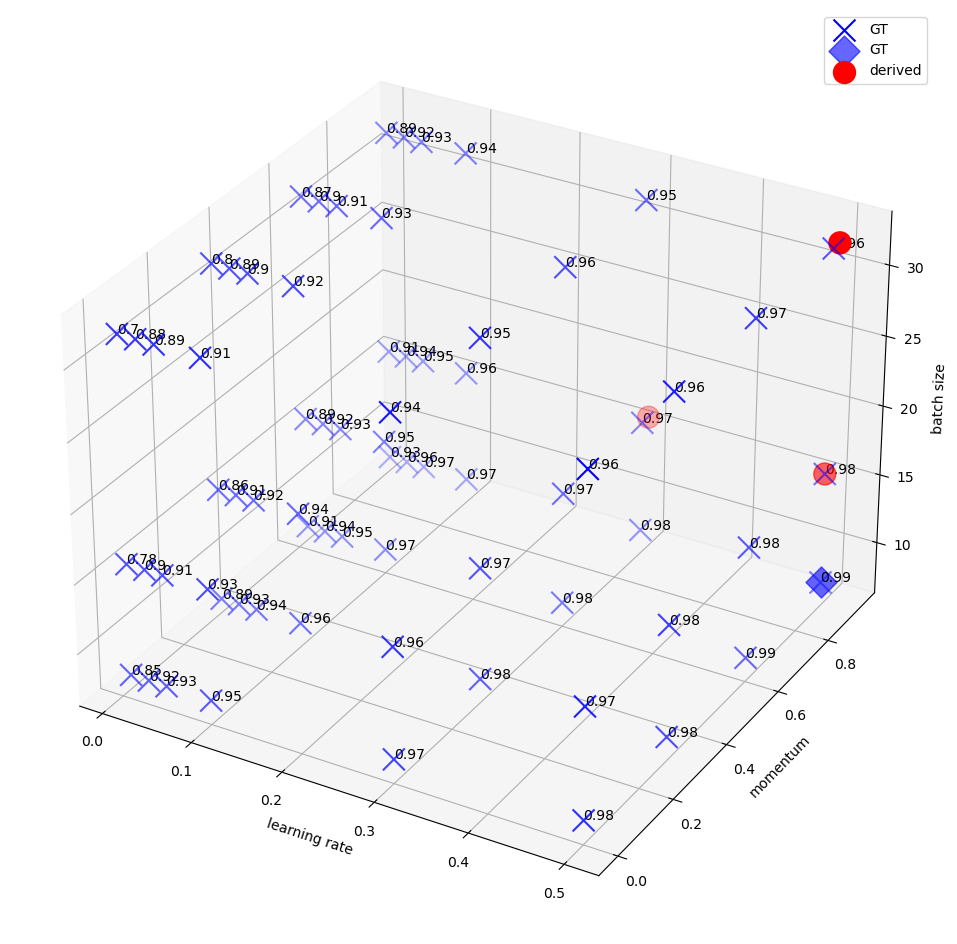

In [16]:
dataset_name = mnist_datasets[1]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

##### 0.1 skew

In 2d: [{'lr_mom_bs': (0.5, 0.9166666666666664, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.97240007)}, {'lr_mom_bs': (0.29999999999999993, 0.9203703703703701, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.97010005)}, {'lr_mom_bs': (0.5, 0.6, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.9847)}]
In 3d: [{'lr_mom_bs': (0.29999999999999993, 0.9099999999999999, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.98280007)}, {'lr_mom_bs': (0.5, 0.9236842105263157, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.97240007)}, {'lr_mom_bs': (0.5, 0.9000000000000001, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.98520005)}]


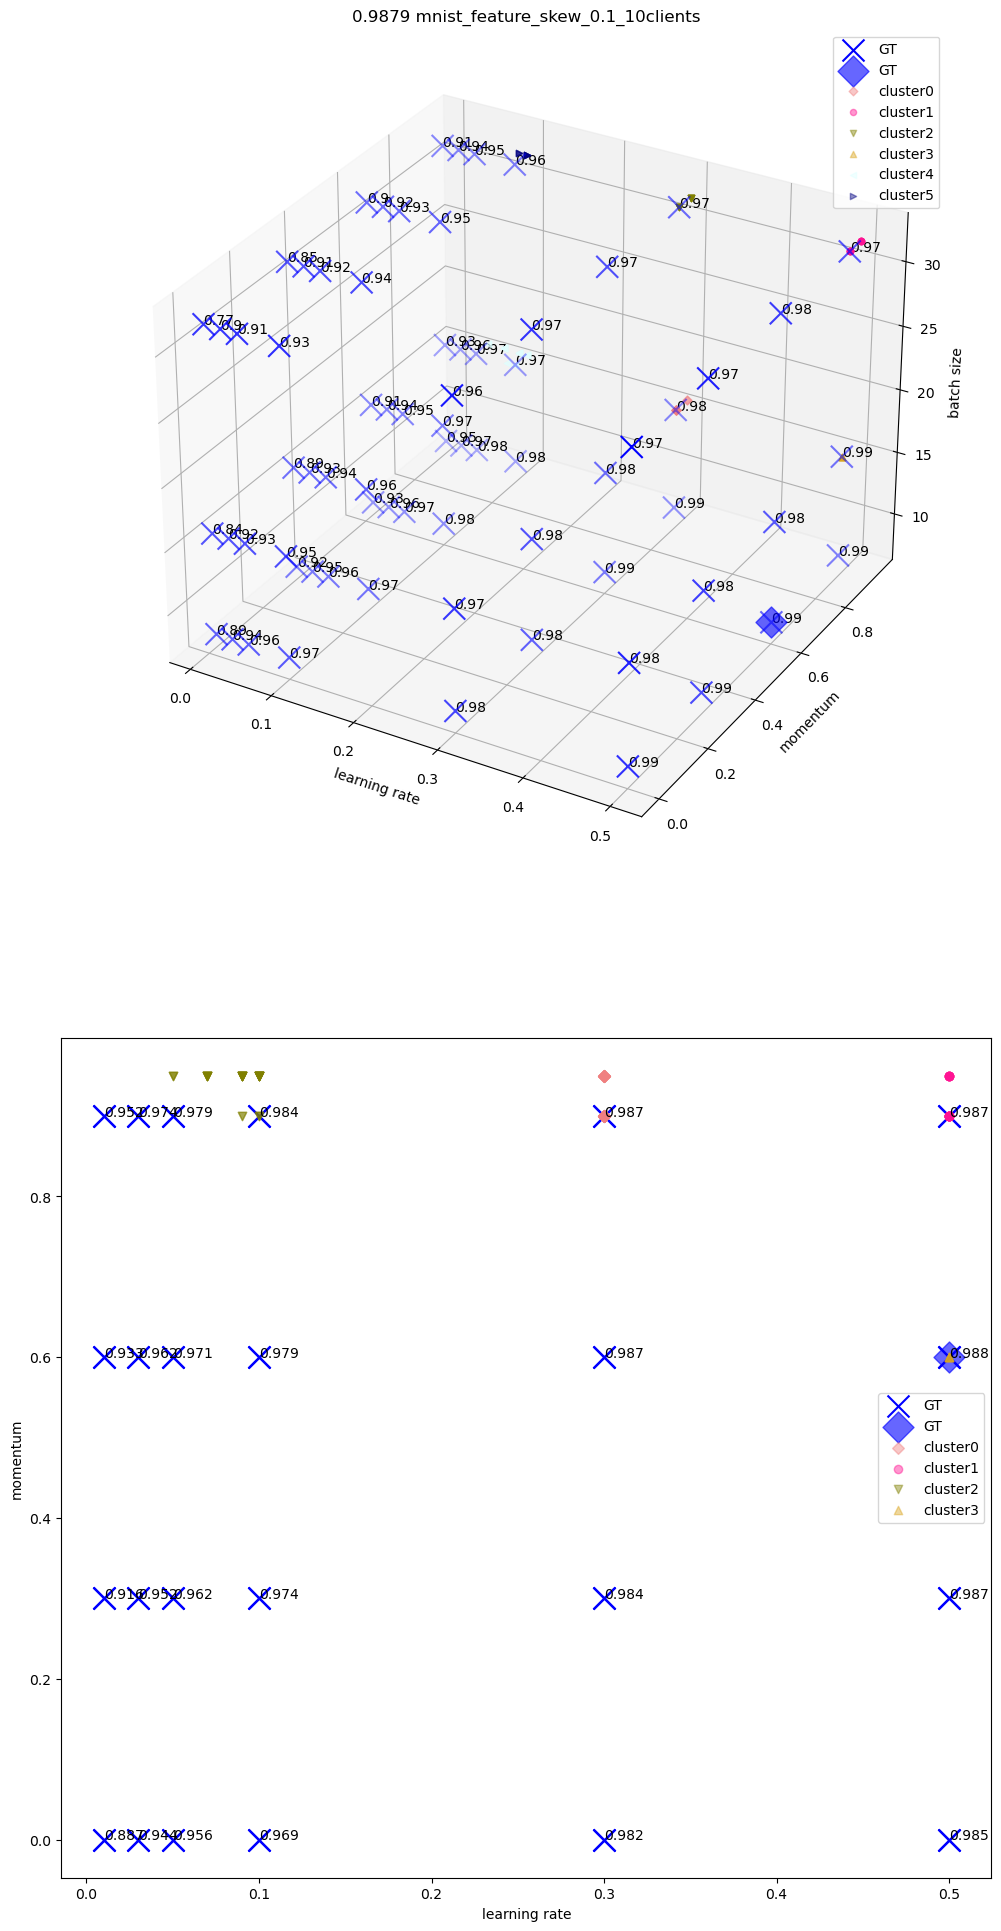

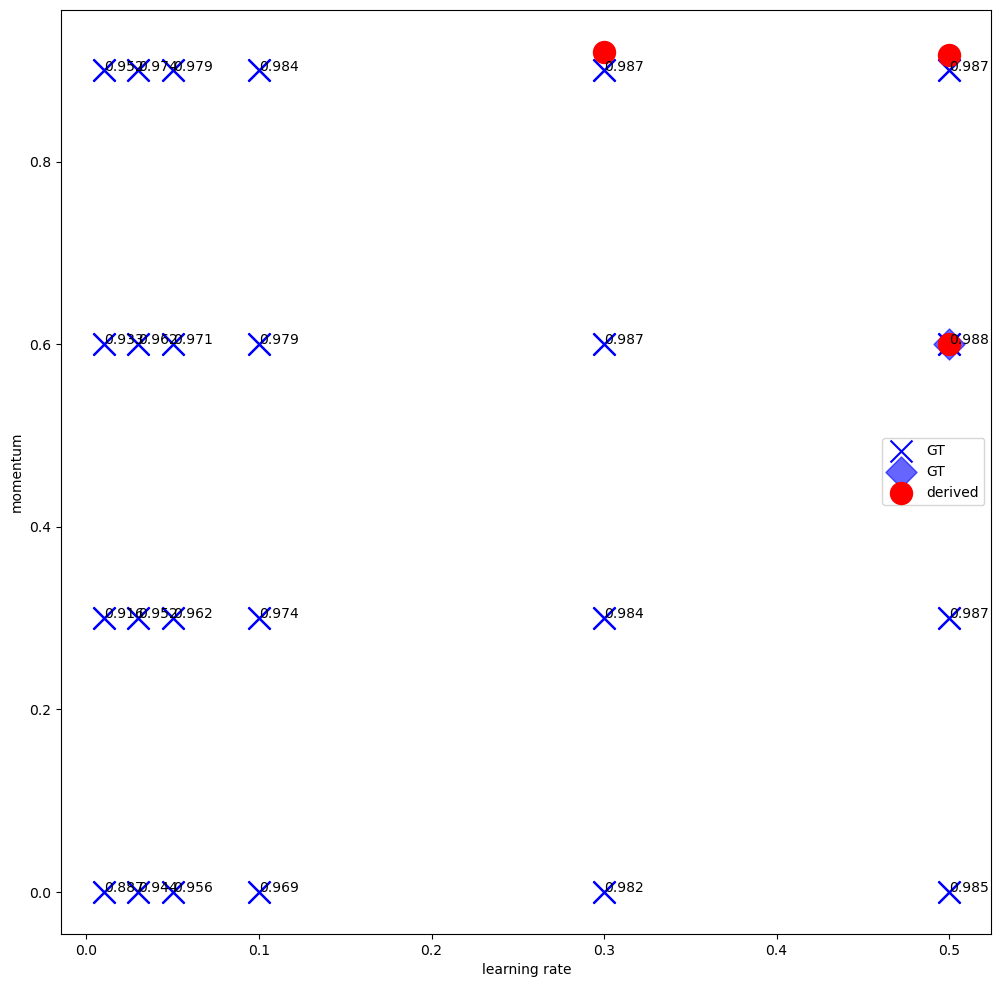

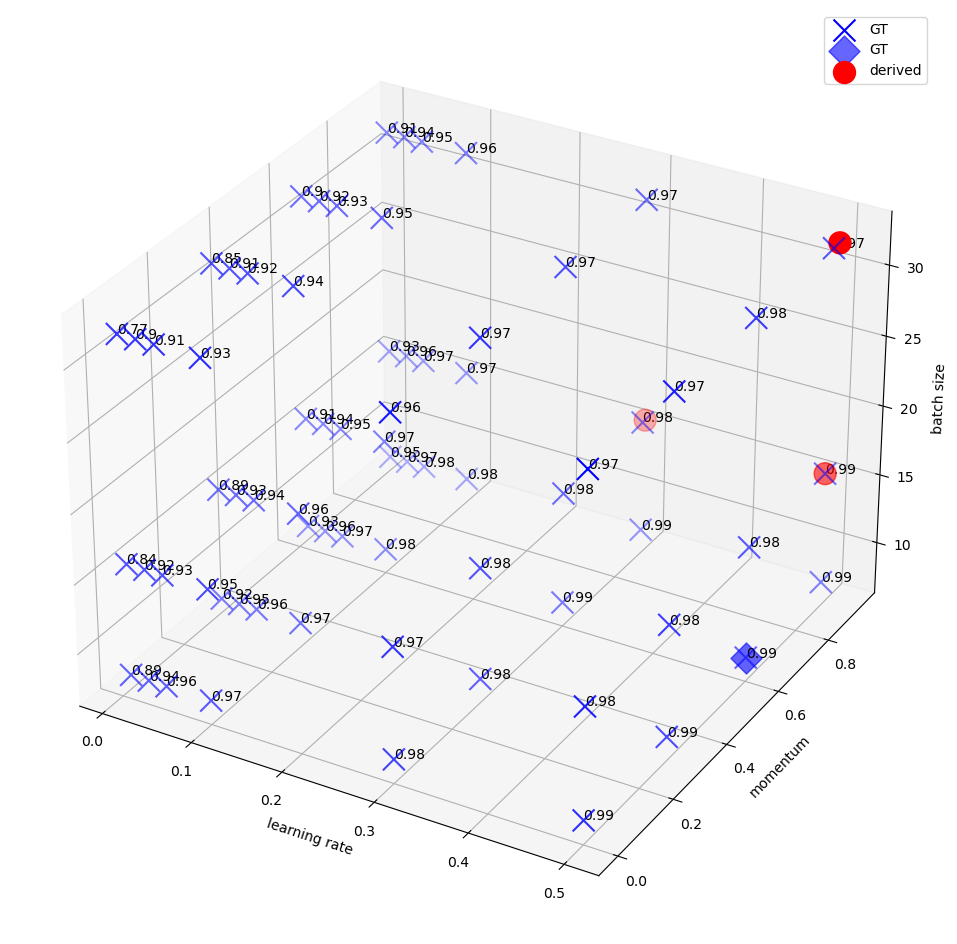

In [17]:
dataset_name = mnist_datasets[2]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

In 2d: [{'lr_mom_bs': (0.3000000000000004, 0.9281250000000001, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.97490007)}, {'lr_mom_bs': (0.5, 0.9138297872340422, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.9574)}, {'lr_mom_bs': (0.08638888888888882, 0.9423611111111119, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.9595001)}]
In 3d: [{'lr_mom_bs': (0.5, 0.9, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.9789001)}, {'lr_mom_bs': (0.3, 0.9310344827586202, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.95320004)}, {'lr_mom_bs': (0.3000000000000001, 0.9257142857142853, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.97490007)}]


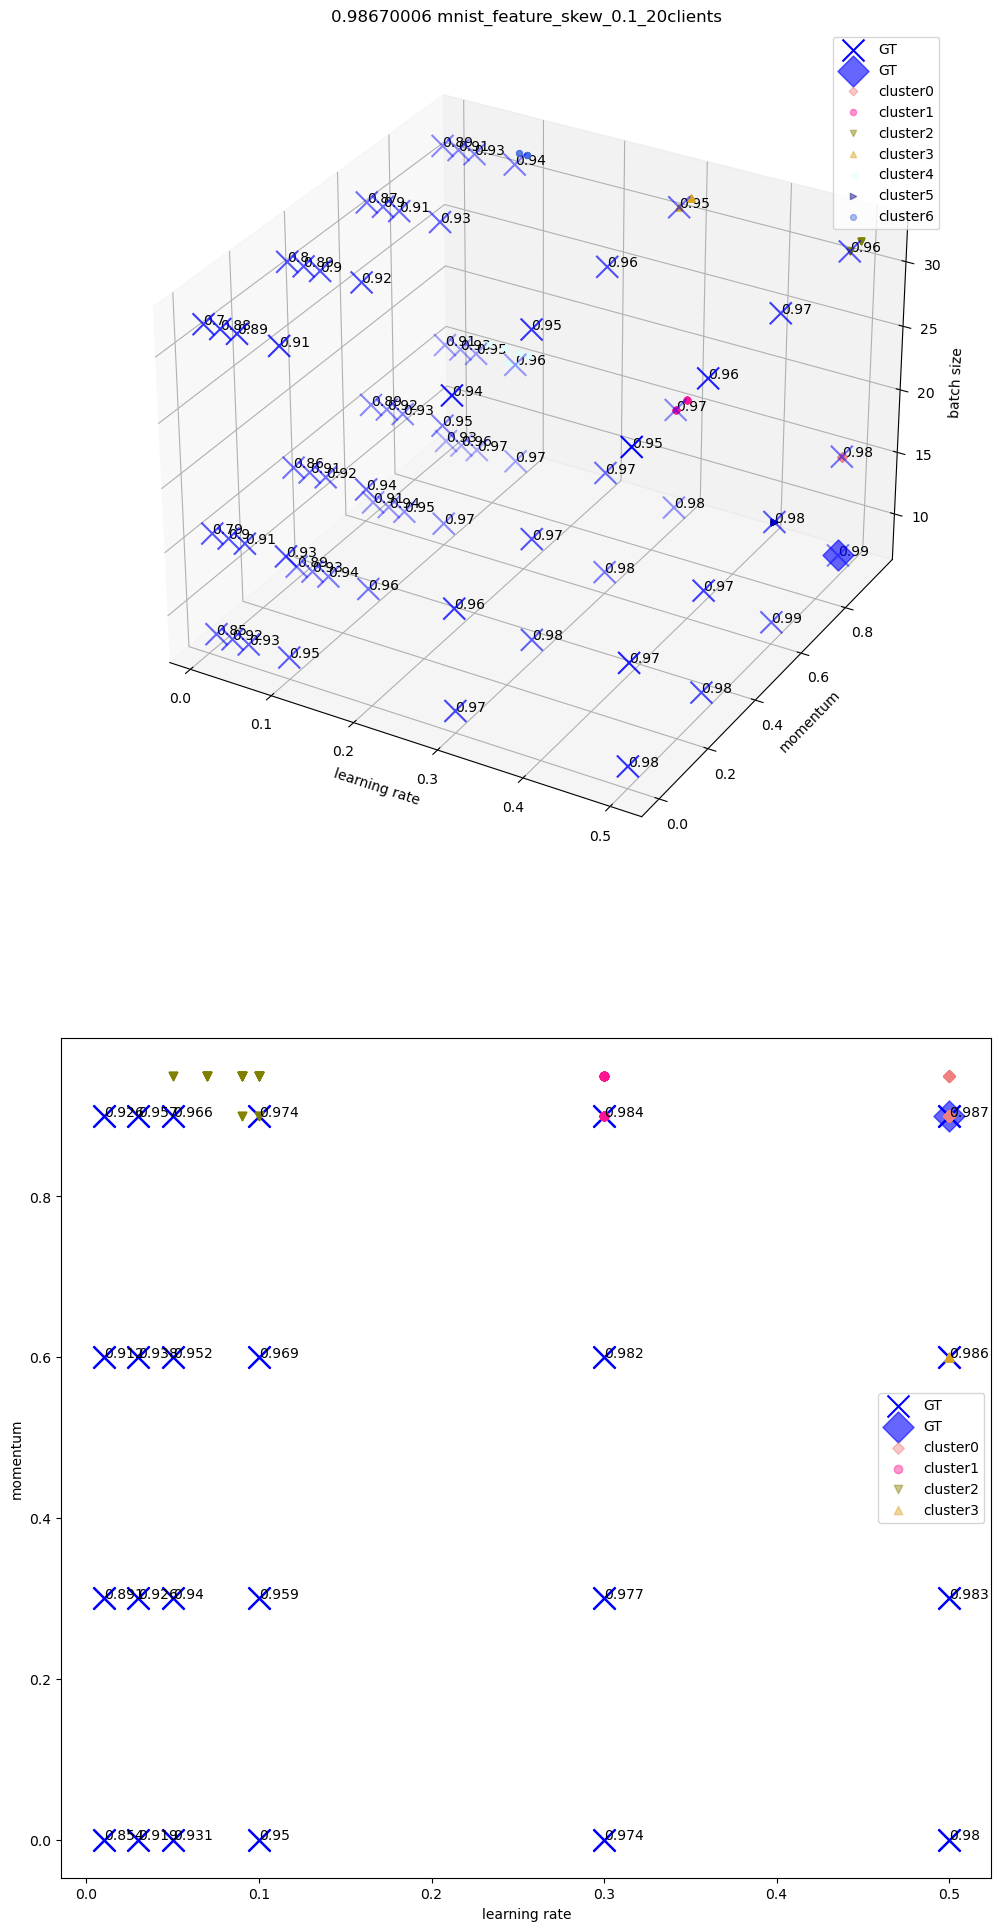

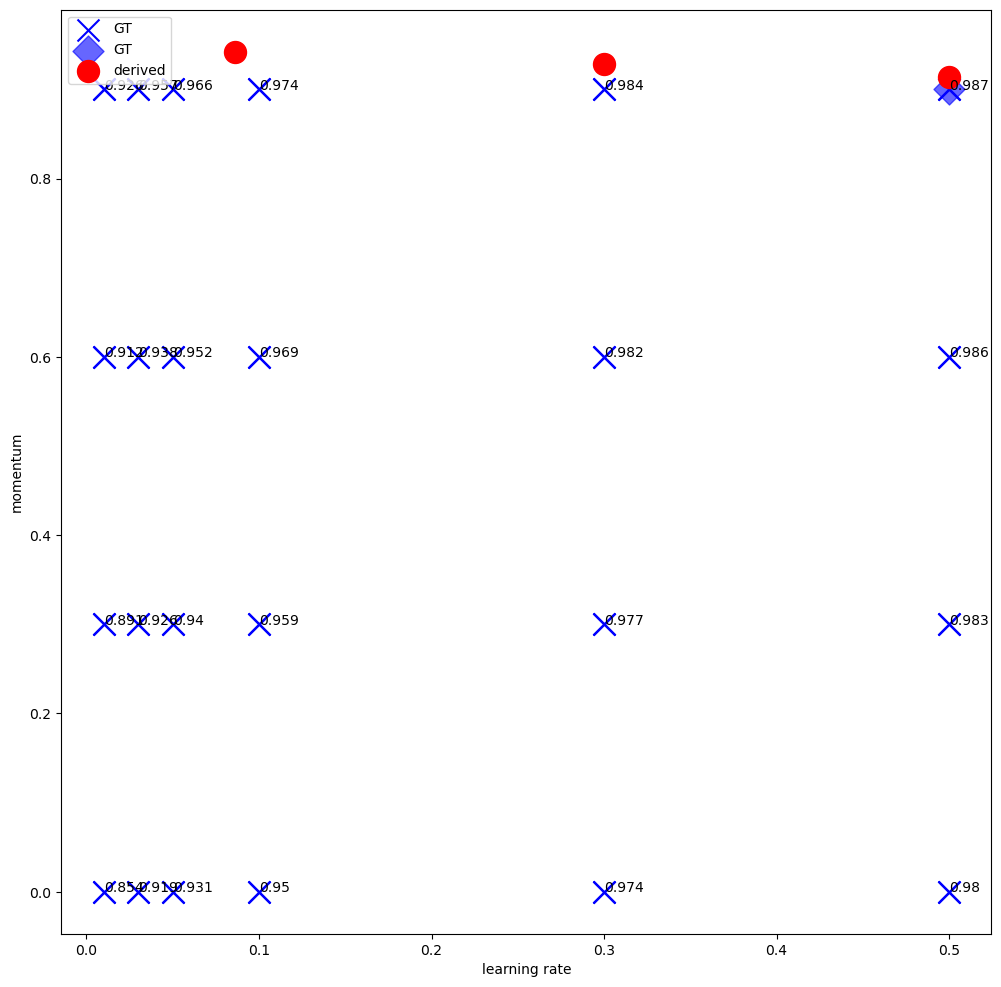

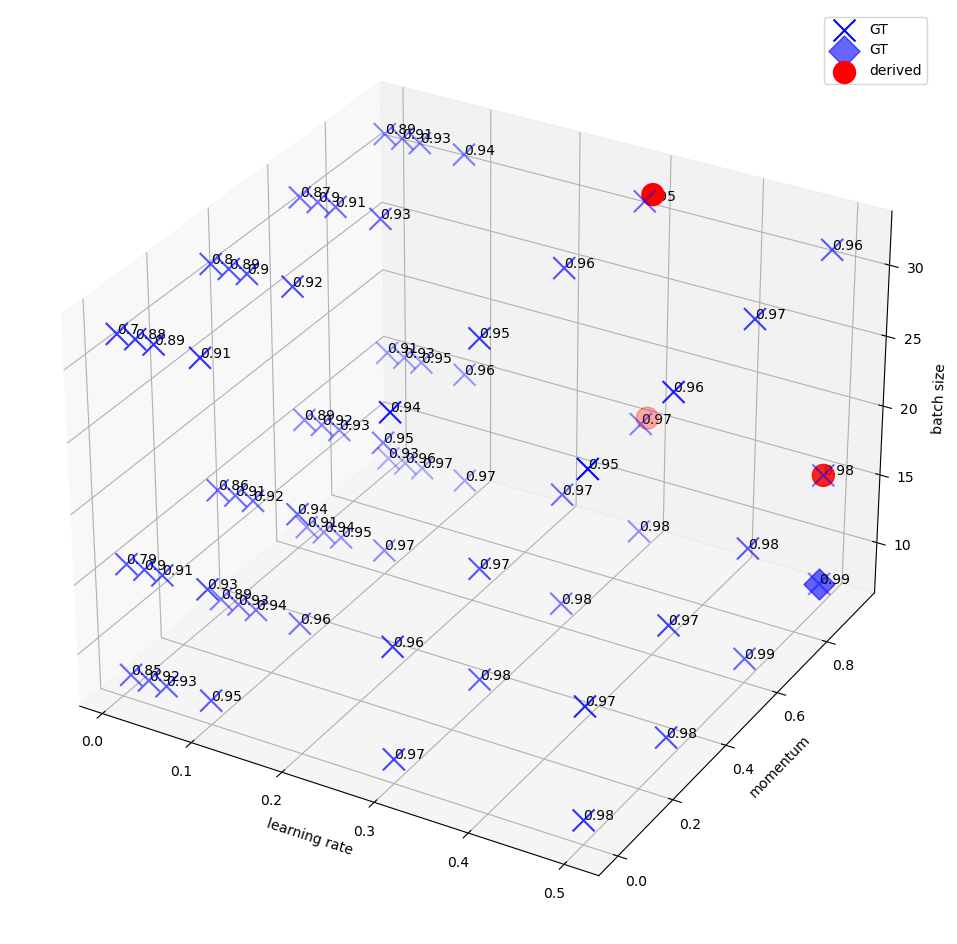

In [18]:
dataset_name = mnist_datasets[3]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

#### EMNIST

In [19]:
emnist_datasets = ['data/emnist_feature_skew_0.02_10clients', 'data/emnist_feature_skew_0.02_20clients',
 'data/emnist_feature_skew_0.1_10clients', 'data/emnist_feature_skew_0.1_20clients']

##### 0.02 skew

In 2d: [{'lr_mom_bs': (0.5, 0.9249999999999995, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.85265166)}, {'lr_mom_bs': (0.3000000000000001, 0.9277777777777771, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.8479063)}, {'lr_mom_bs': (0.09181818181818184, 0.9499999999999996, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.83788246)}]
In 3d: [{'lr_mom_bs': (0.29999999999999993, 0.9249999999999998, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.8479063)}, {'lr_mom_bs': (0.5, 0.9249999999999998, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.85265166)}, {'lr_mom_bs': (0.5, 0.9249999999999998, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.849703)}]


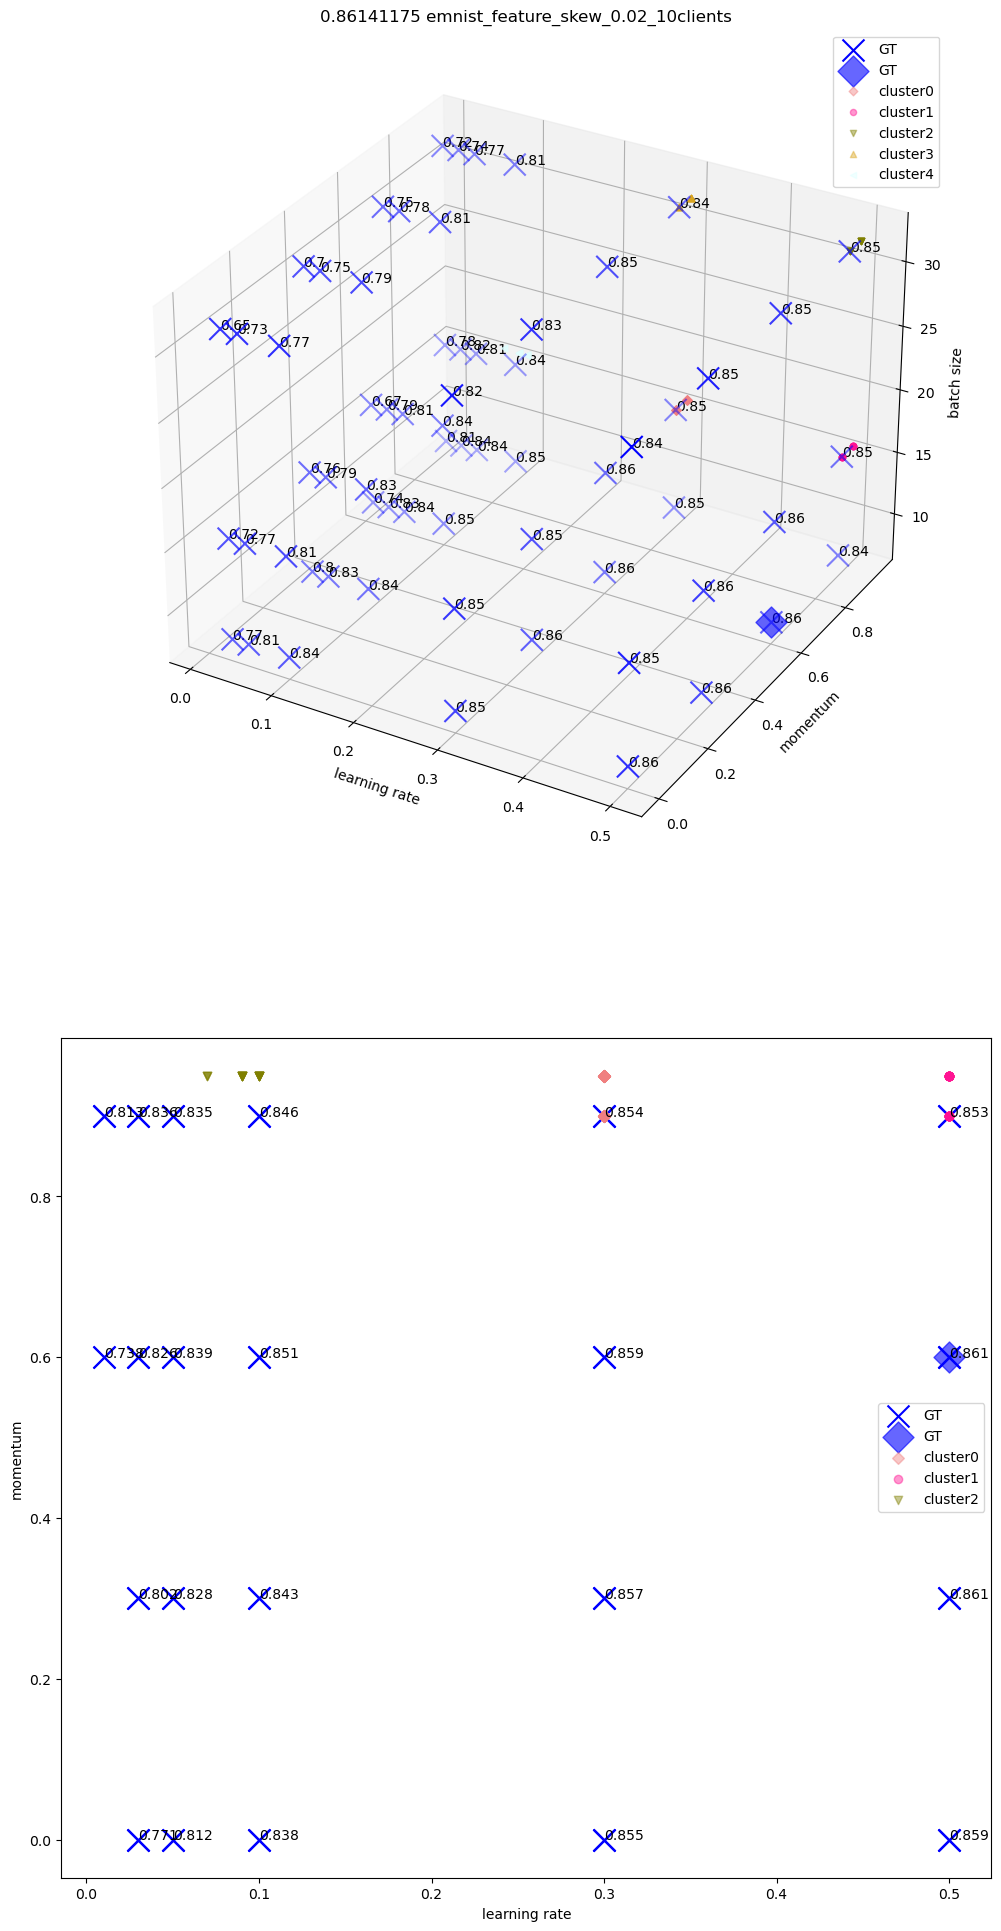

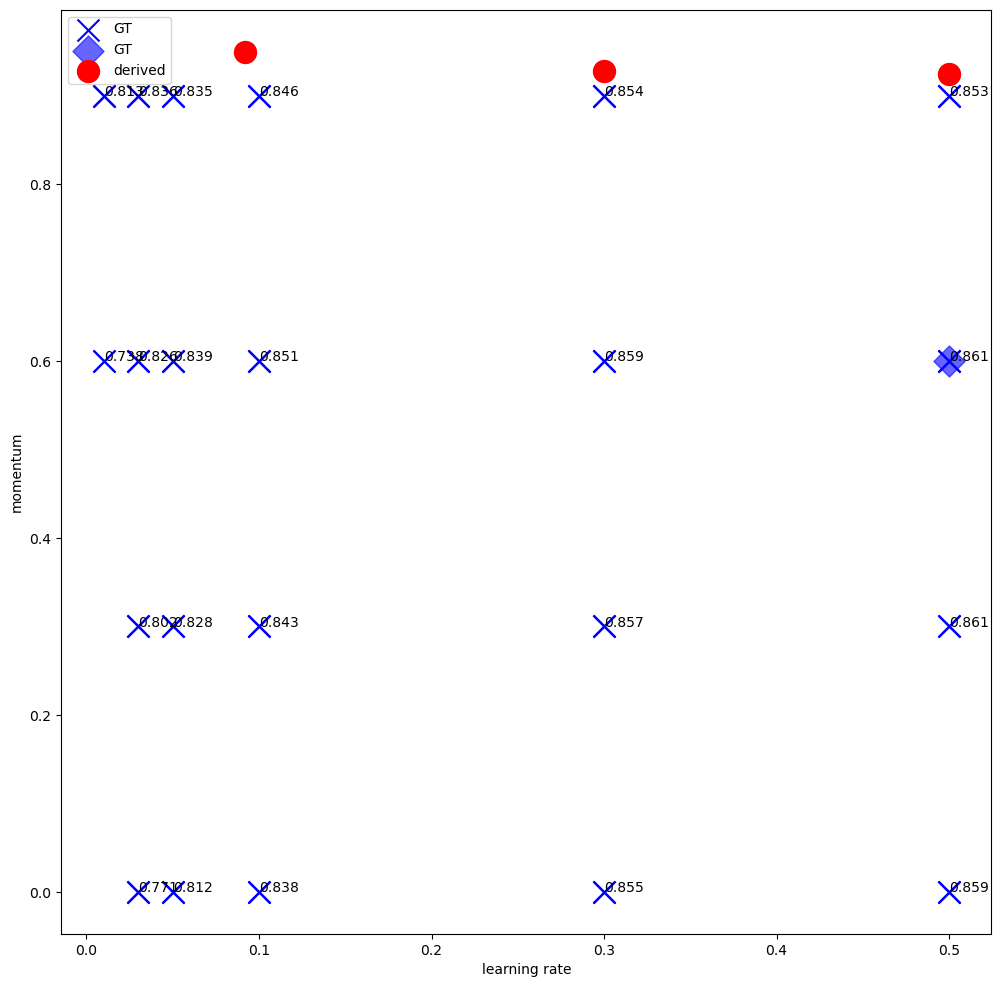

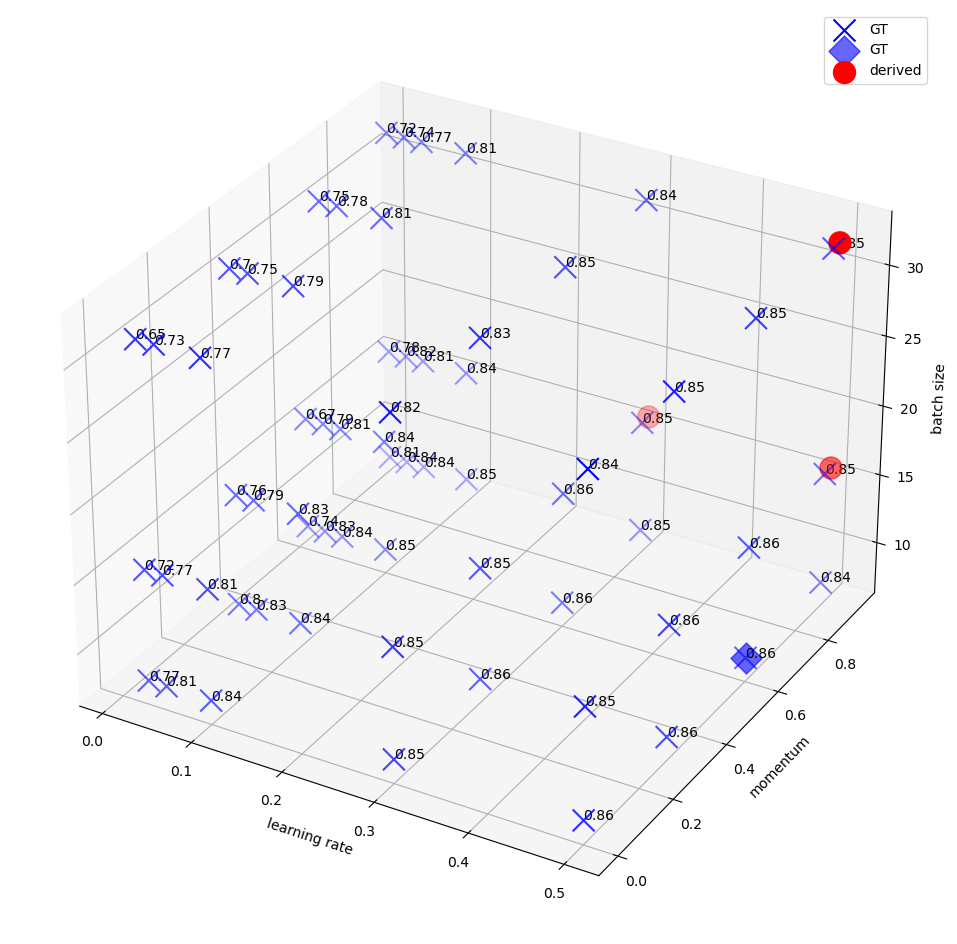

In [20]:
dataset_name = emnist_datasets[0]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

In 2d: [{'lr_mom_bs': (0.5, 0.925000000000001, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.84746784)}, {'lr_mom_bs': (0.30000000000000043, 0.9277777777777781, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.84044427)}]
In 3d: [{'lr_mom_bs': (0.5, 0.9249999999999995, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.84746784)}, {'lr_mom_bs': (0.30000000000000016, 0.9249999999999995, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.84044427)}, {'lr_mom_bs': (0.5, 0.9249999999999993, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.81515265)}]


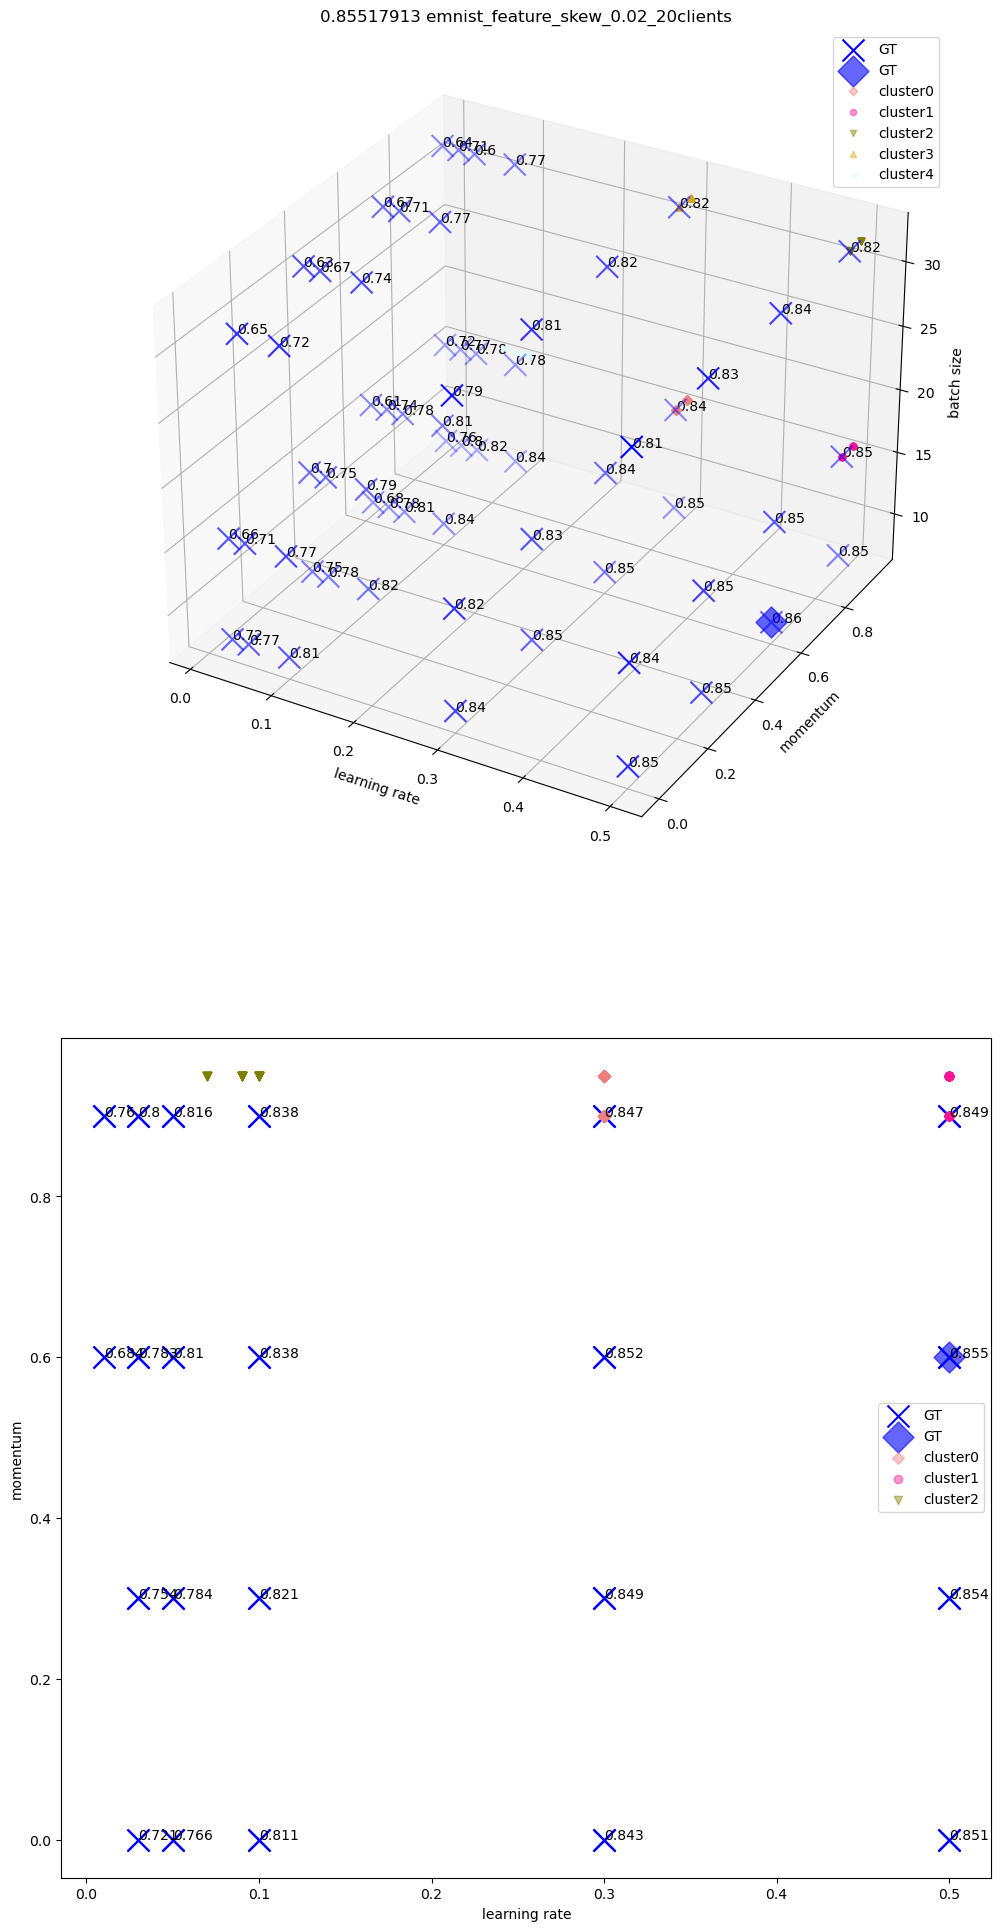

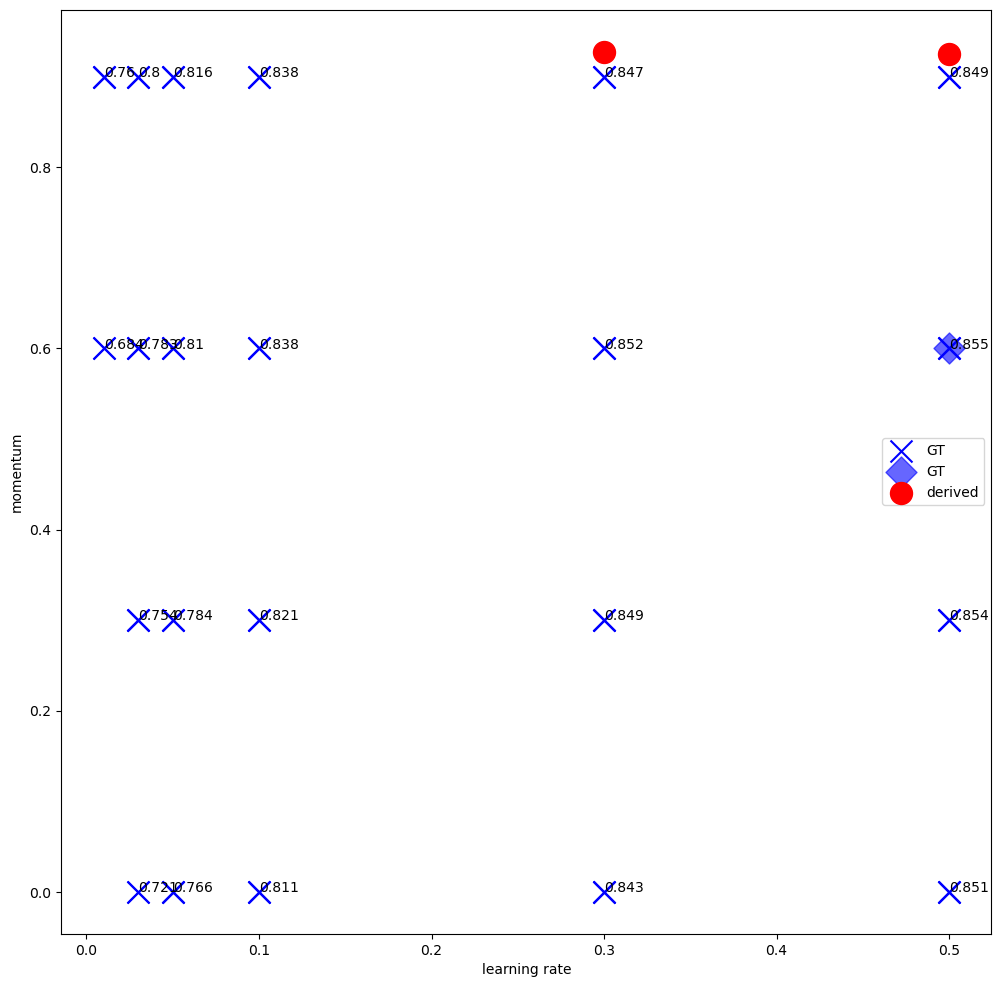

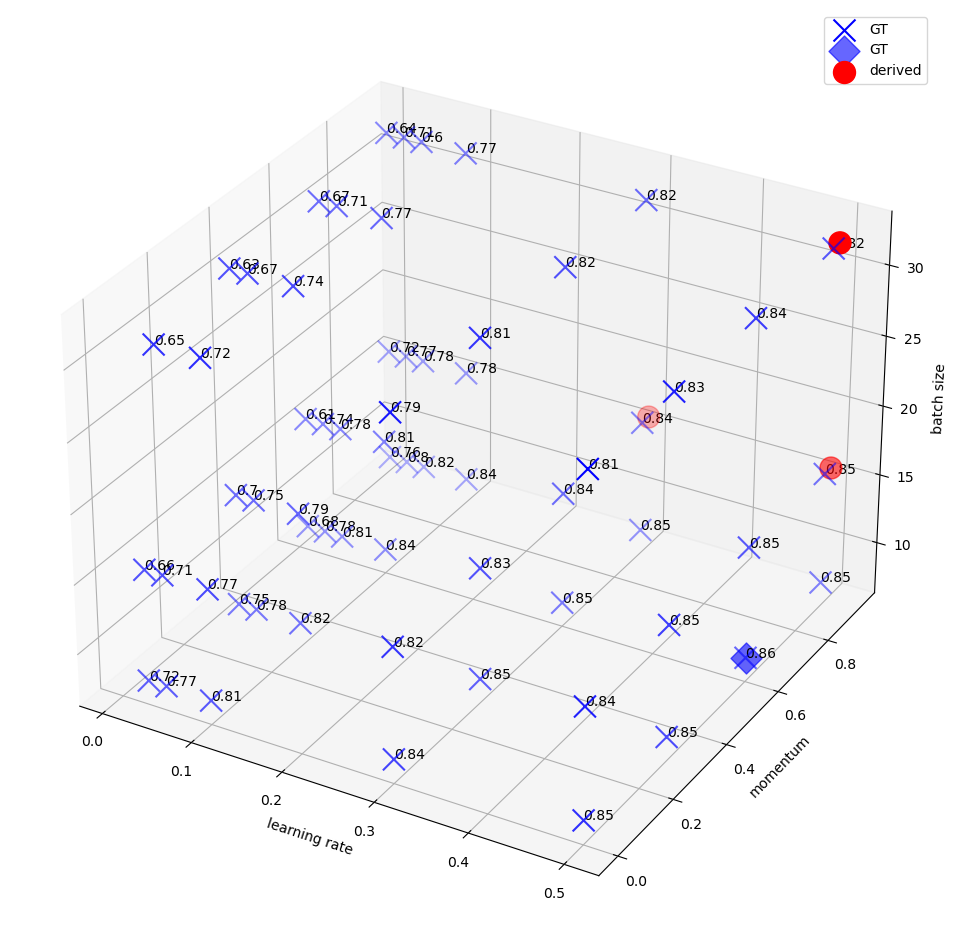

In [21]:
dataset_name = emnist_datasets[1]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

##### 0.1 skew

In 2d: [{'lr_mom_bs': (0.5, 0.9249999999999996, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.8510011)}, {'lr_mom_bs': (0.3000000000000001, 0.9277777777777774, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.8487917)}, {'lr_mom_bs': (0.08875000000000001, 0.9499999999999996, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.8367563)}]
In 3d: [{'lr_mom_bs': (0.29999999999999993, 0.925, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.8487917)}, {'lr_mom_bs': (0.5, 0.925, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.8510011)}, {'lr_mom_bs': (0.5, 0.9249999999999999, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.8477429)}]


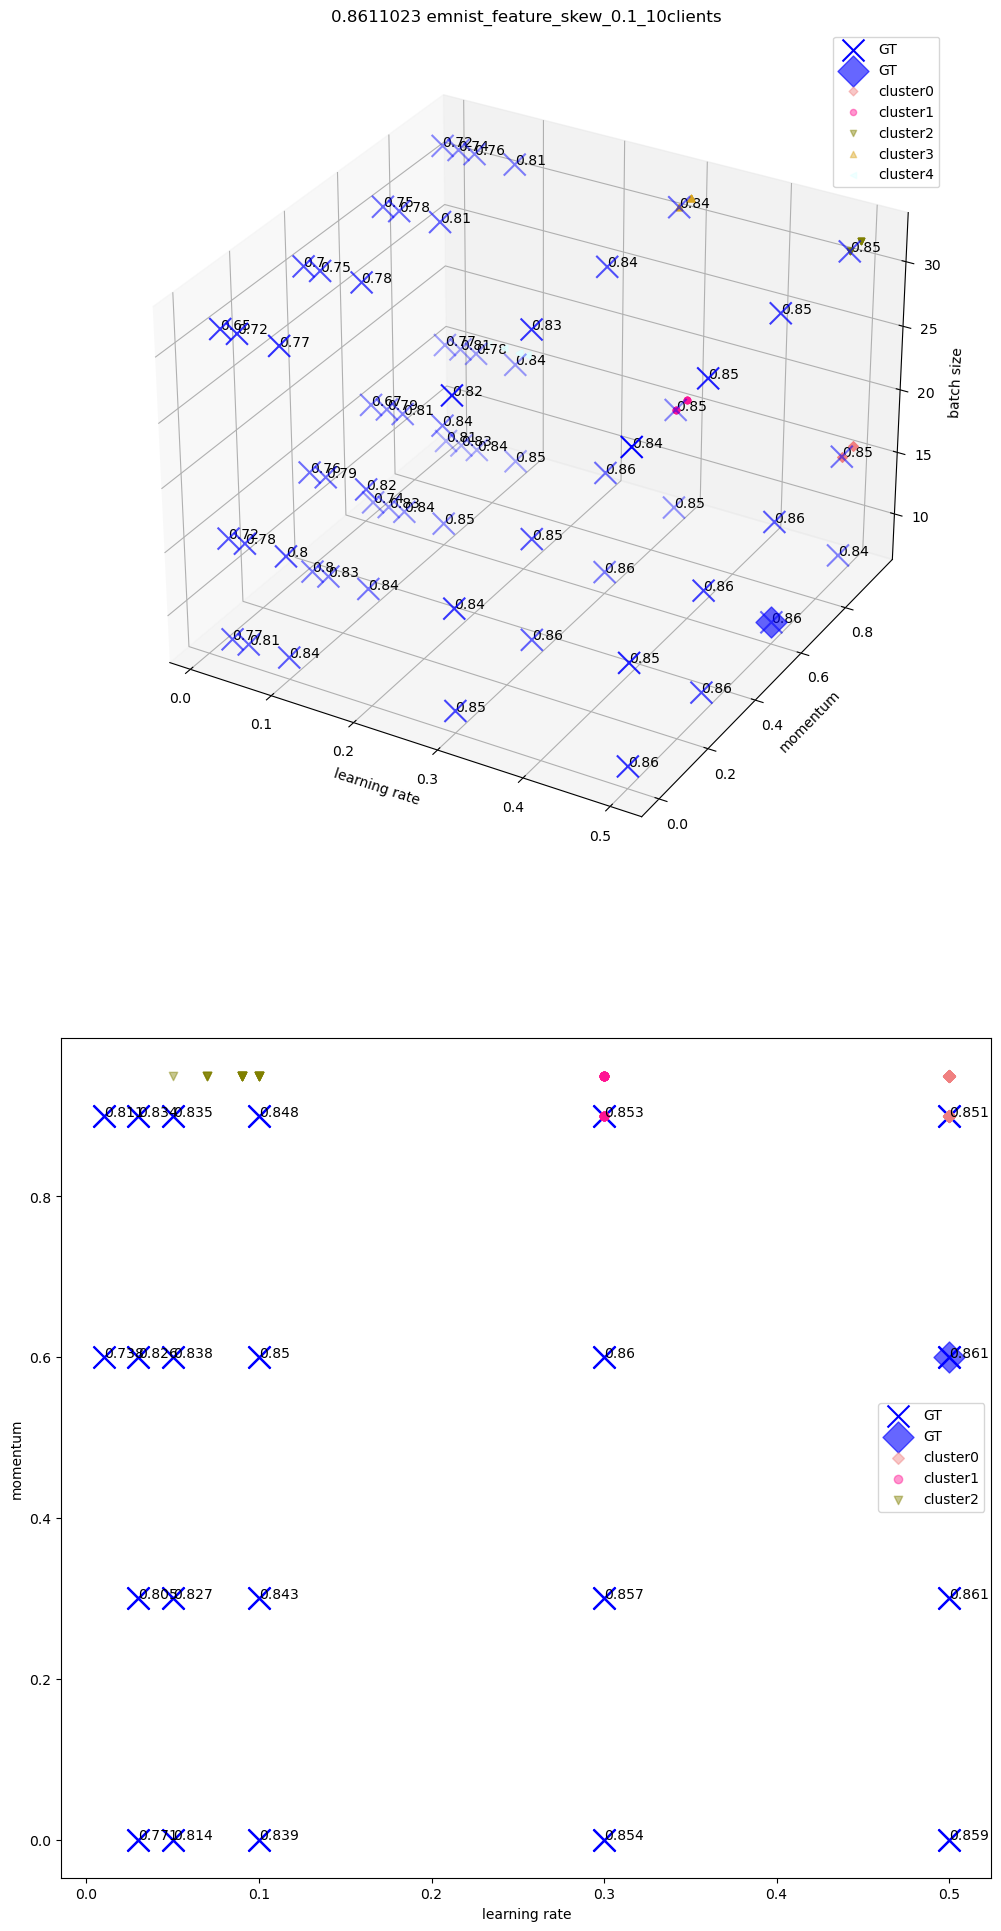

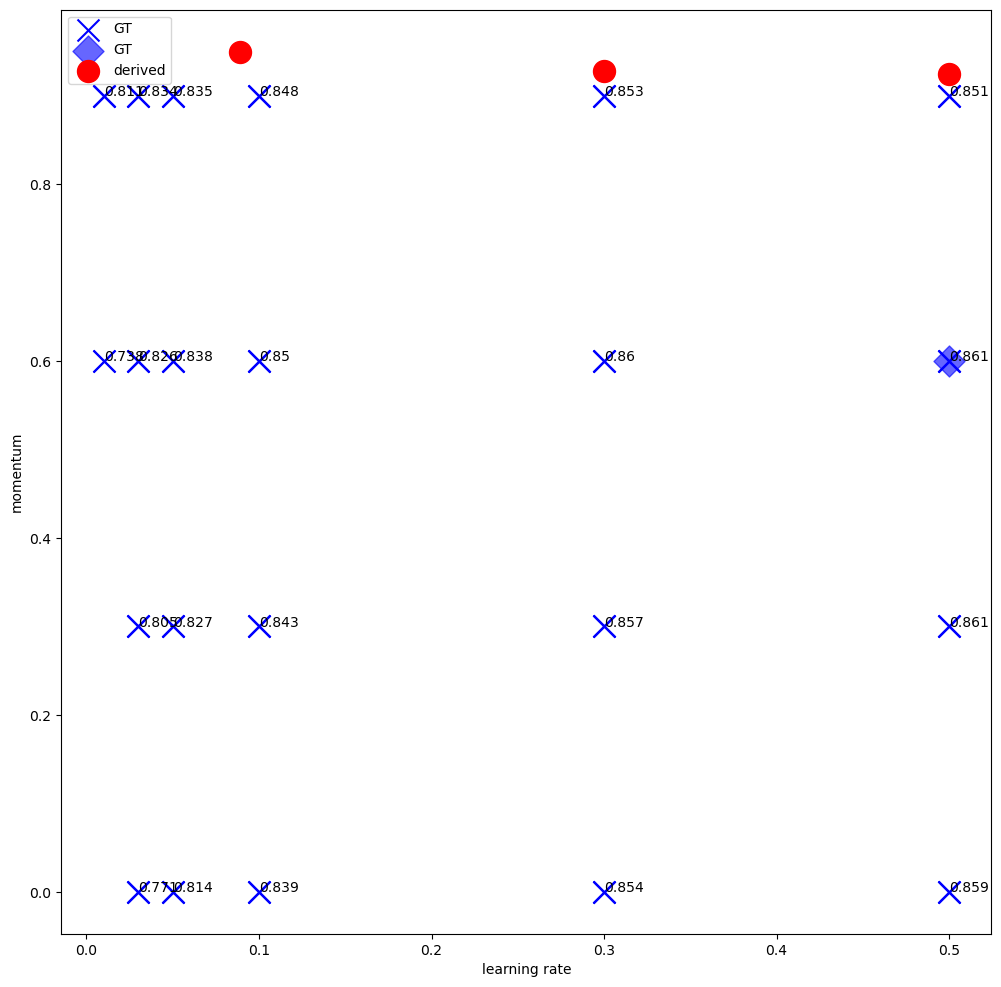

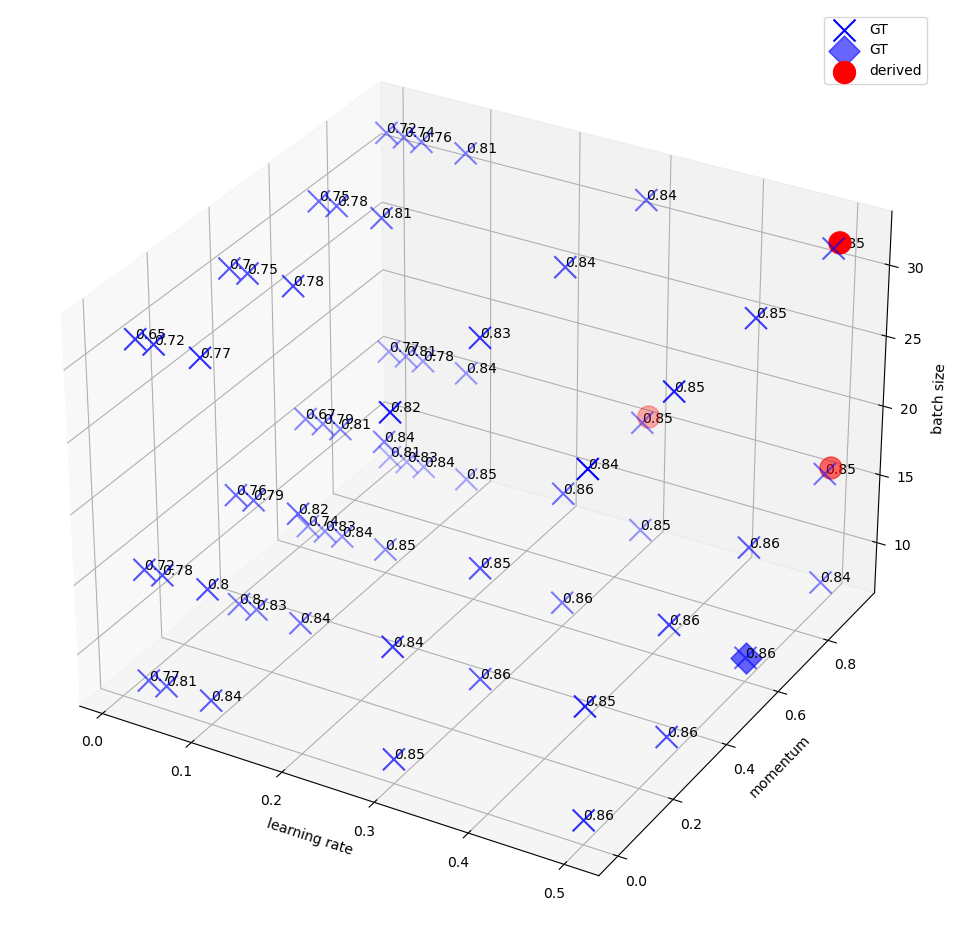

In [22]:
dataset_name = emnist_datasets[2]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

In 2d: [{'lr_mom_bs': (0.5, 0.9250000000000005, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.8459118)}, {'lr_mom_bs': (0.30000000000000043, 0.9281690140845074, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.8396018)}]
In 3d: [{'lr_mom_bs': (0.5, 0.9249999999999996, 16), 'closest_lr_mom_bs_acc': (0.5, 0.9, 16.0, 0.8459118)}, {'lr_mom_bs': (0.30000000000000016, 0.9249999999999995, 16), 'closest_lr_mom_bs_acc': (0.3, 0.9, 16.0, 0.8396018)}, {'lr_mom_bs': (0.5, 0.9249999999999993, 32), 'closest_lr_mom_bs_acc': (0.5, 0.9, 32.0, 0.8290794)}]


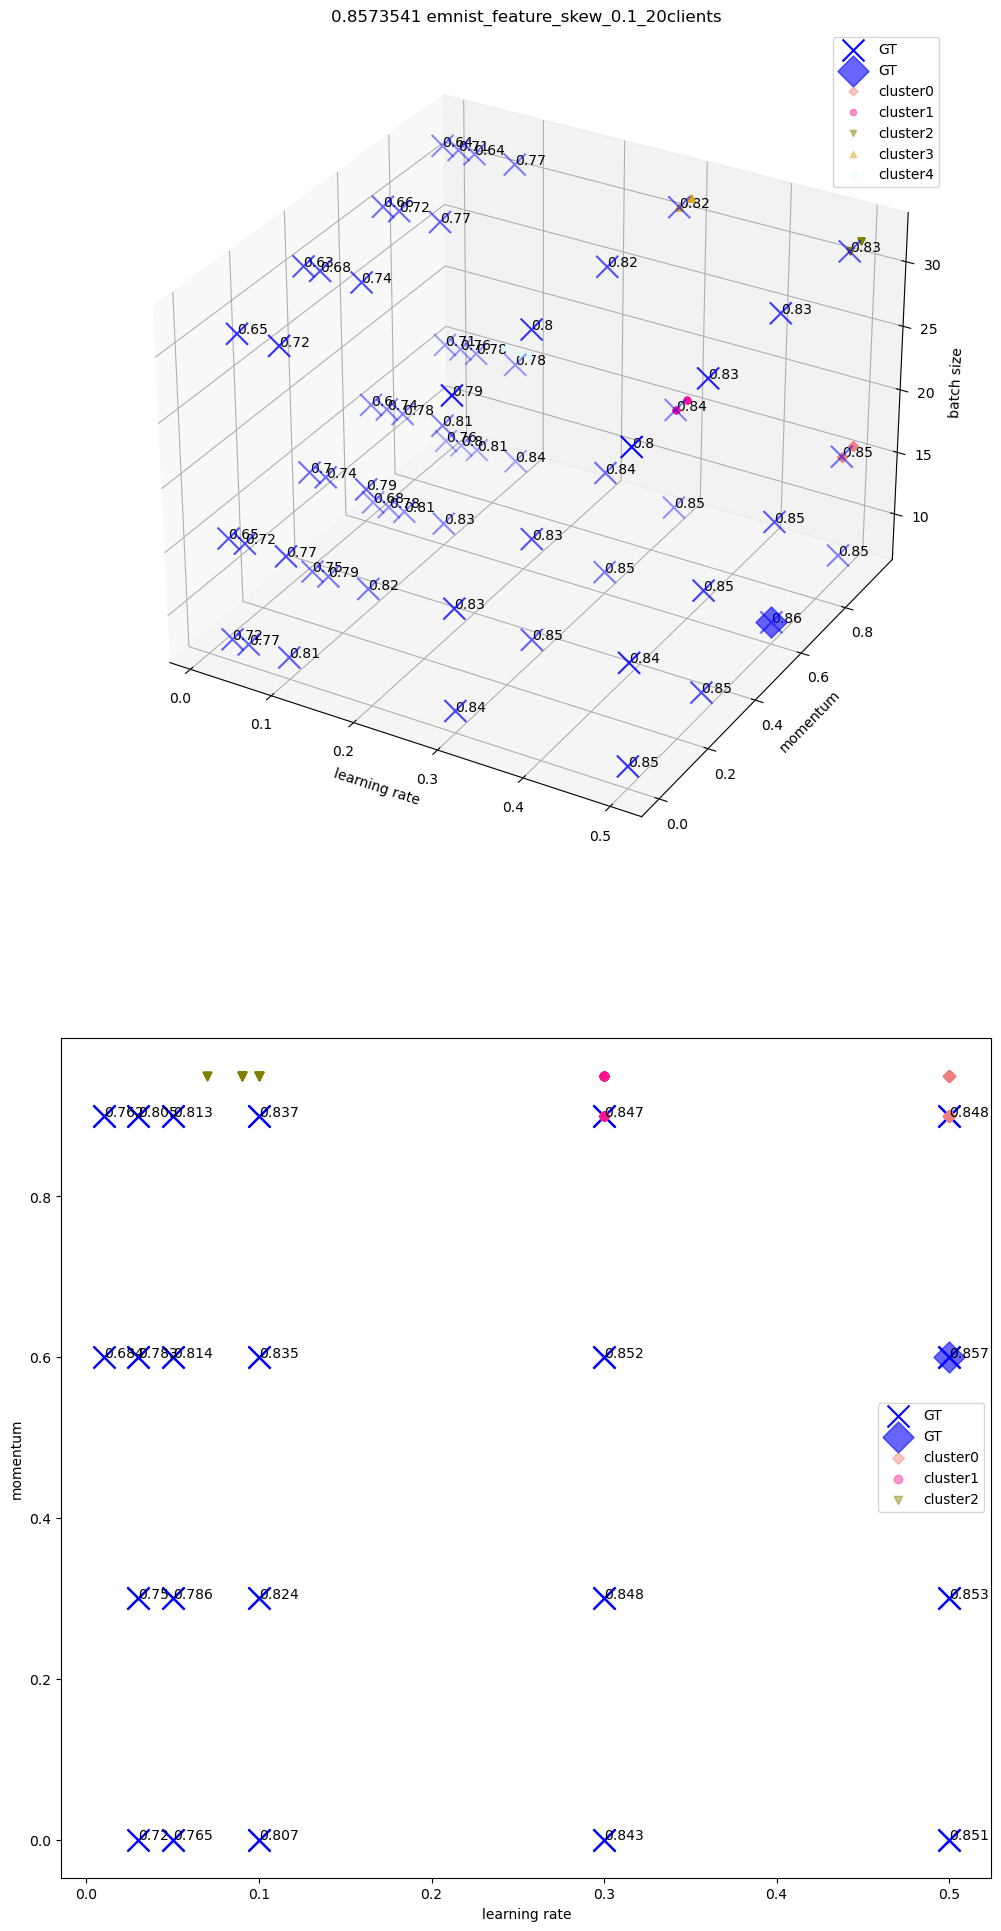

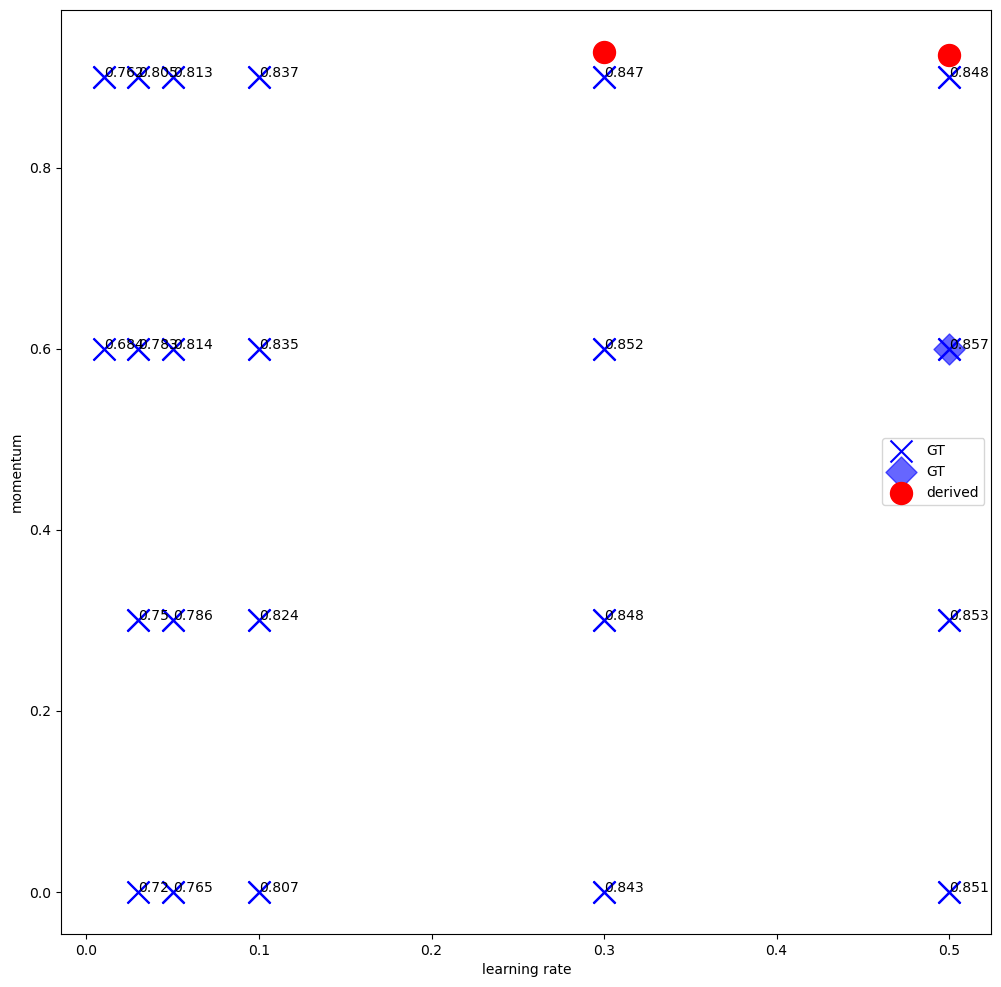

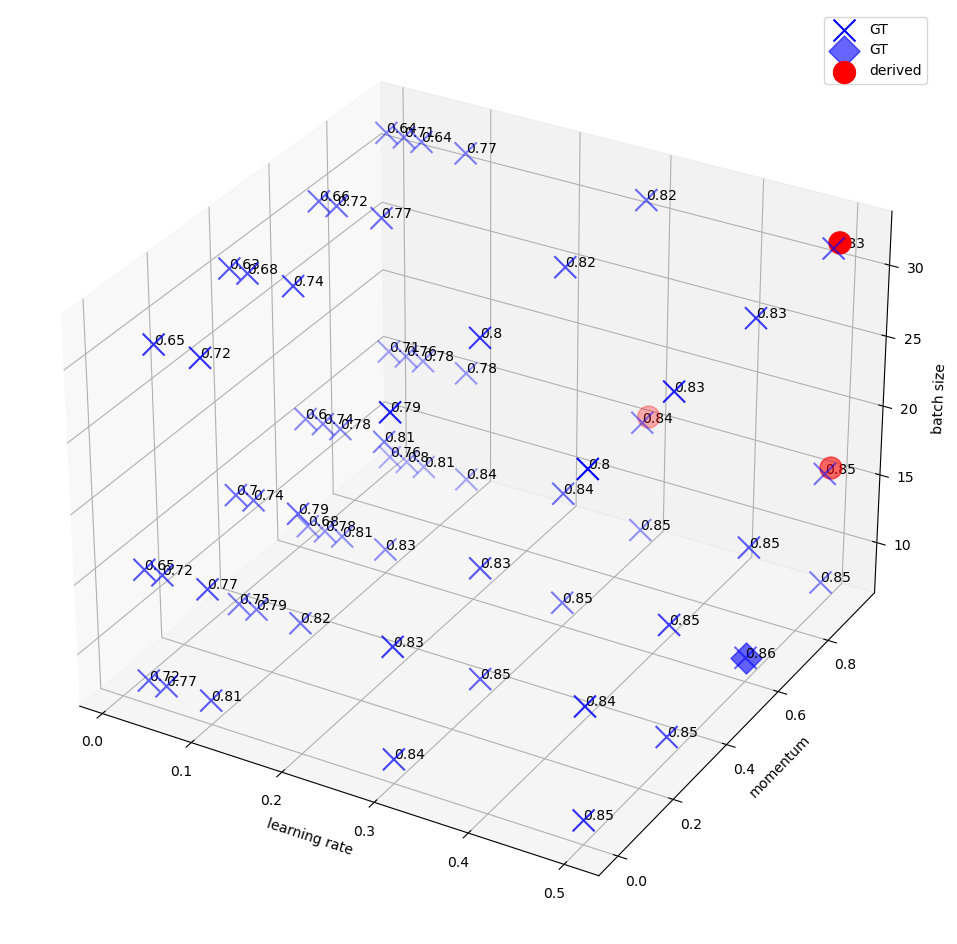

In [23]:
dataset_name = emnist_datasets[3]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

#### SVHN

In [24]:
svhn_datasets = ['data/svhn_cropped_feature_skew_0.02_10clients', 'data/svhn_cropped_feature_skew_0.02_20clients',
'data/svhn_cropped_feature_skew_0.1_10clients', 'data/svhn_cropped_feature_skew_0.1_20clients']

##### 0.02 skew

In 2d: [{'lr_mom_bs': (0.3, 0.6, 16), 'closest_lr_mom_bs_acc': (0.3, 0.6, 16.0, 0.8517594)}, {'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.86674094)}, {'lr_mom_bs': (0.5, 0.3, 16), 'closest_lr_mom_bs_acc': (0.5, 0.3, 16.0, 0.8602105)}]
In 3d: [{'lr_mom_bs': (0.3, 0.6, 16), 'closest_lr_mom_bs_acc': (0.3, 0.6, 16.0, 0.8517594)}, {'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.86674094)}, {'lr_mom_bs': (0.5, 0.3, 16), 'closest_lr_mom_bs_acc': (0.5, 0.3, 16.0, 0.8602105)}]


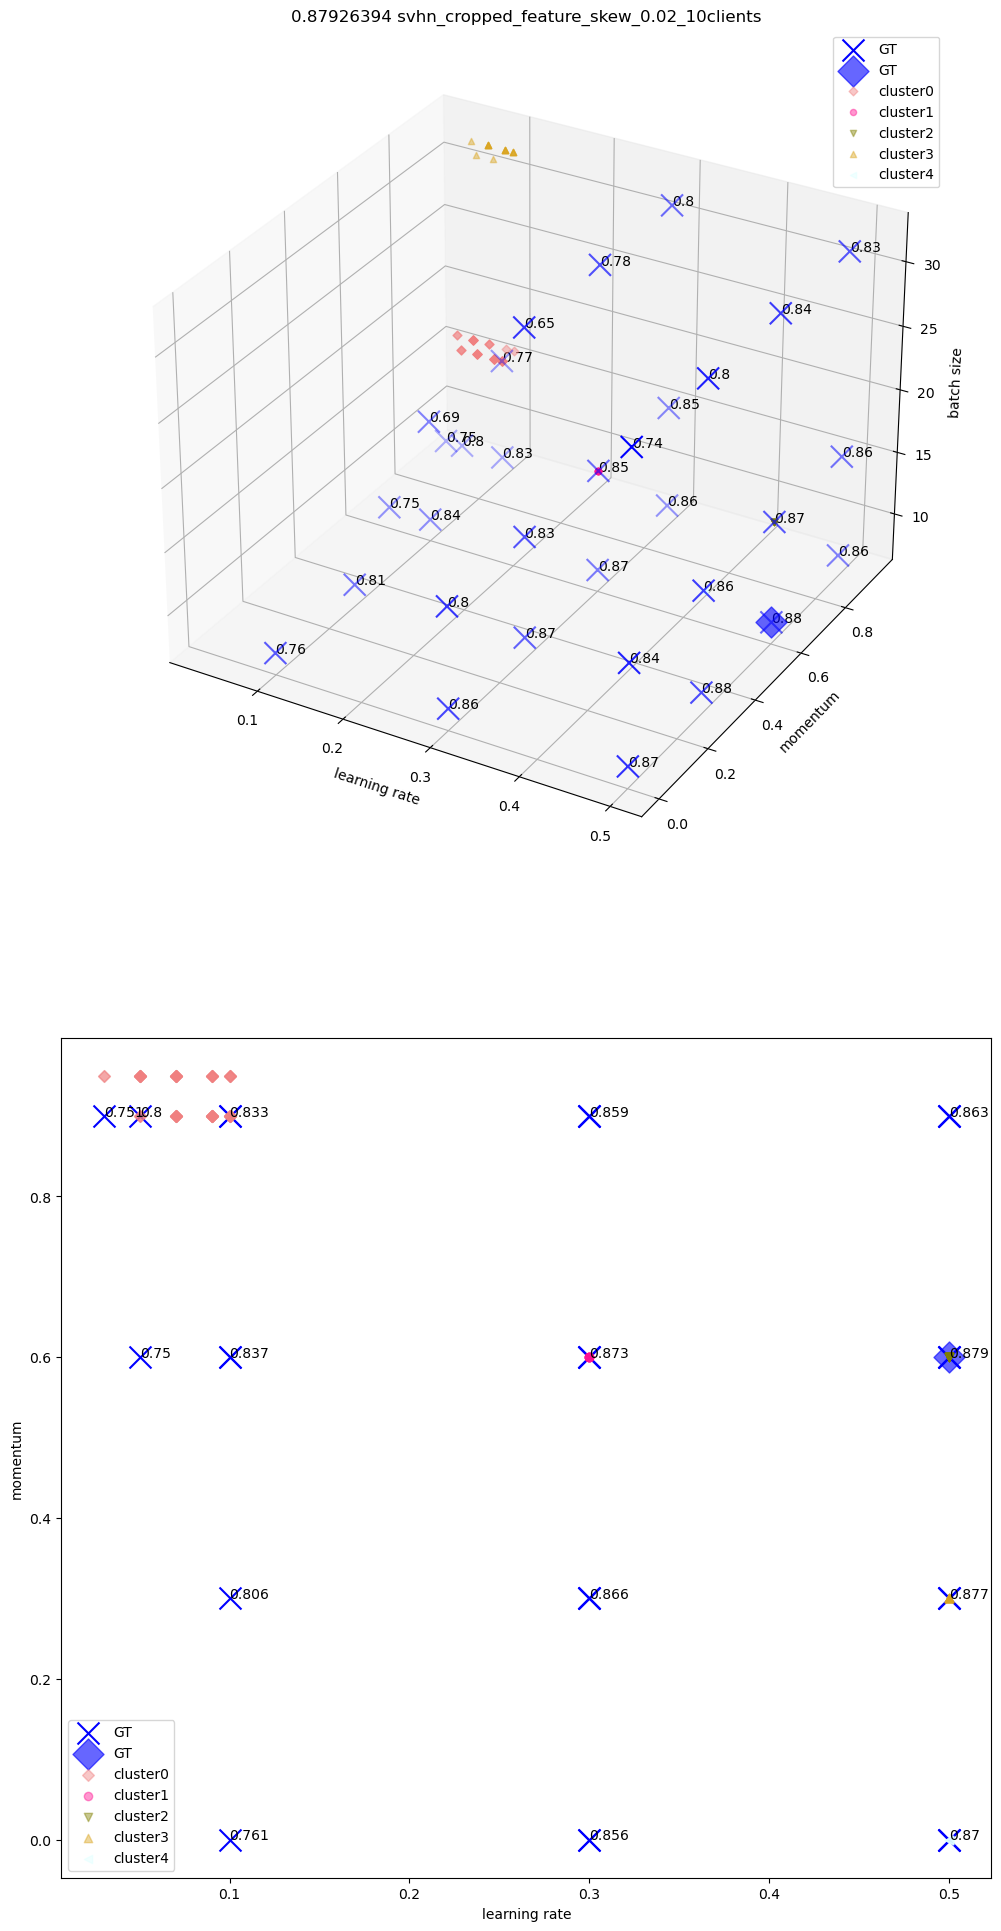

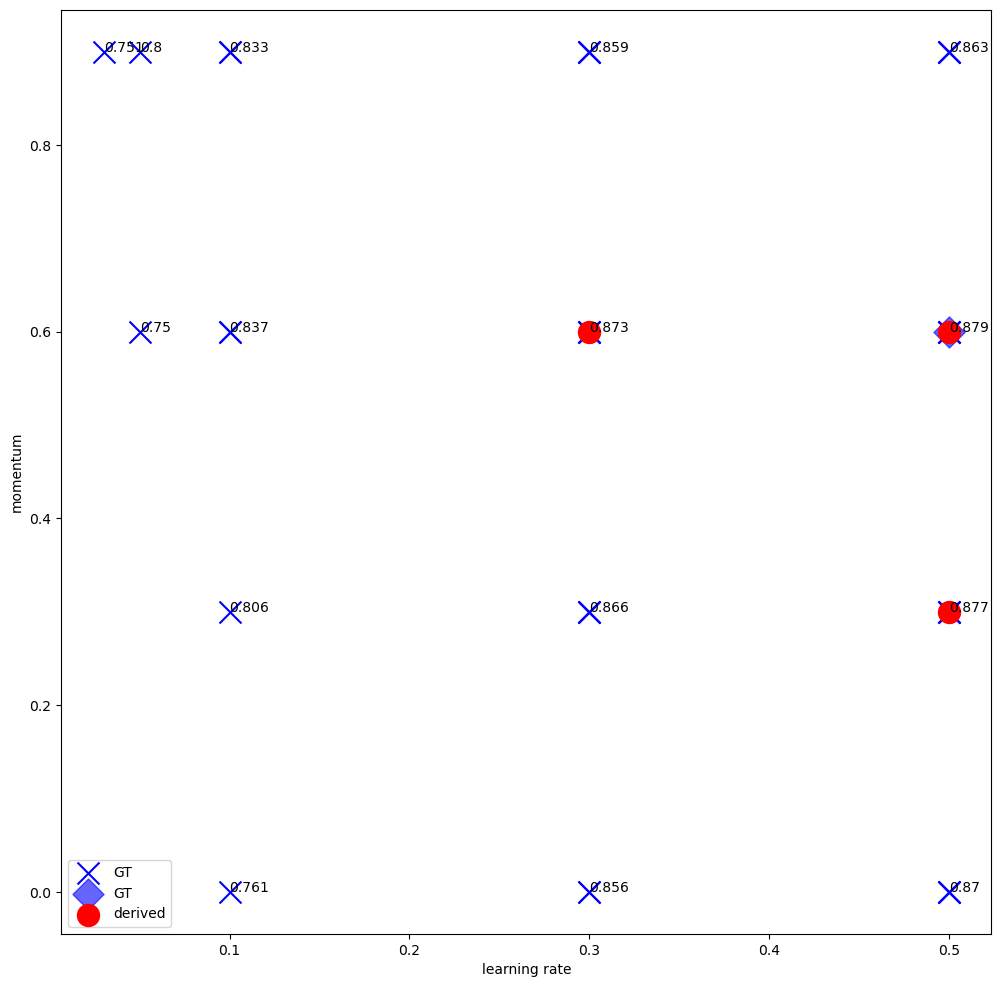

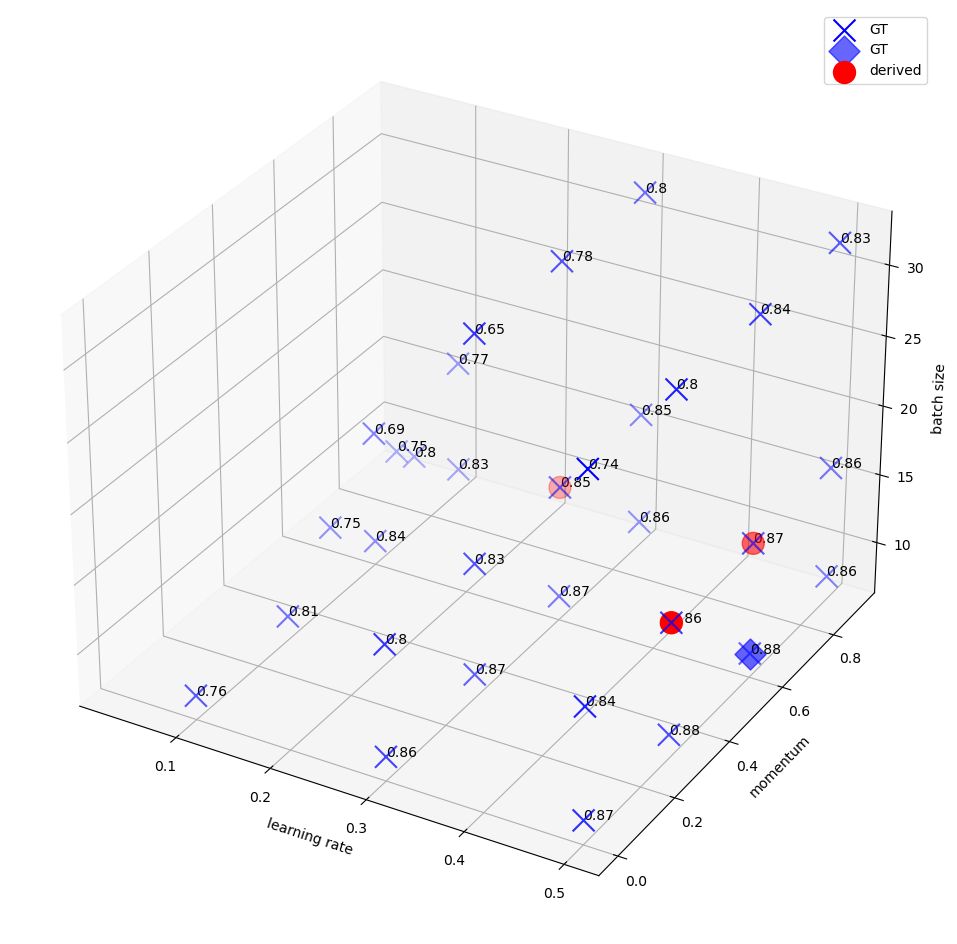

In [25]:
dataset_name = svhn_datasets[0]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

In 2d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.83608633)}]
In 3d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.83608633)}]


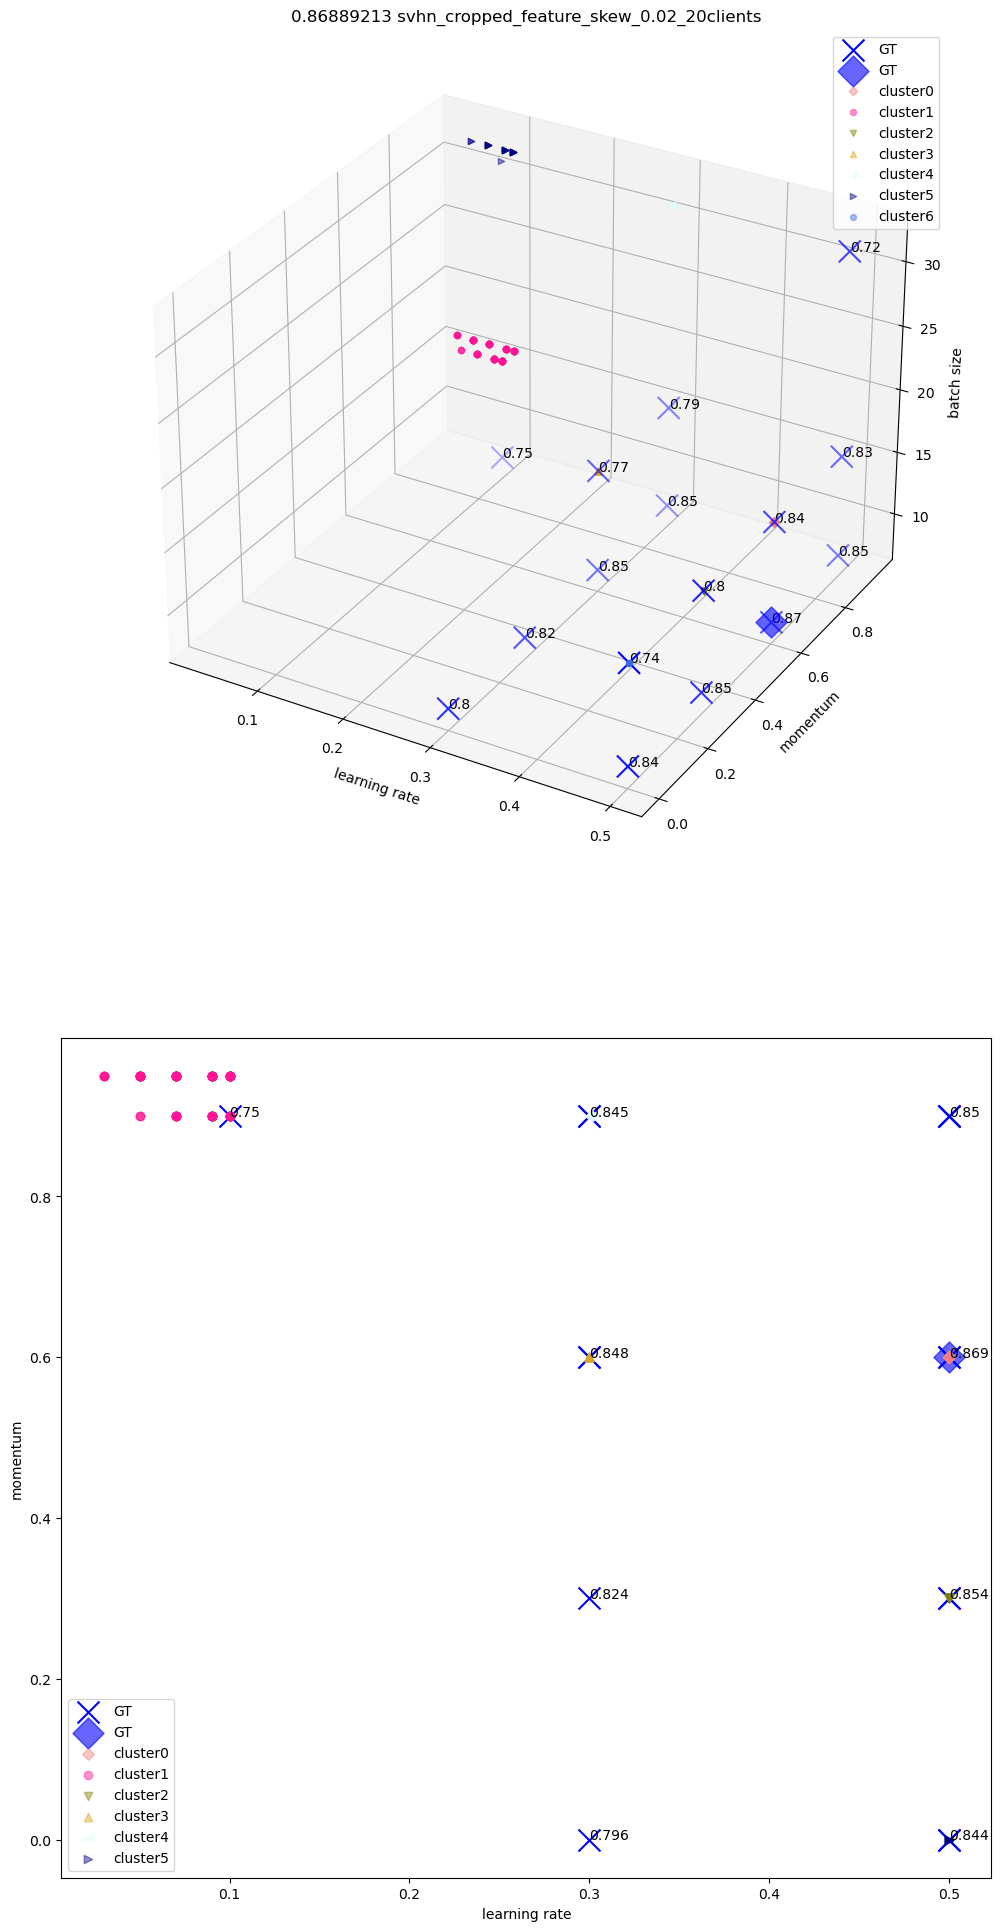

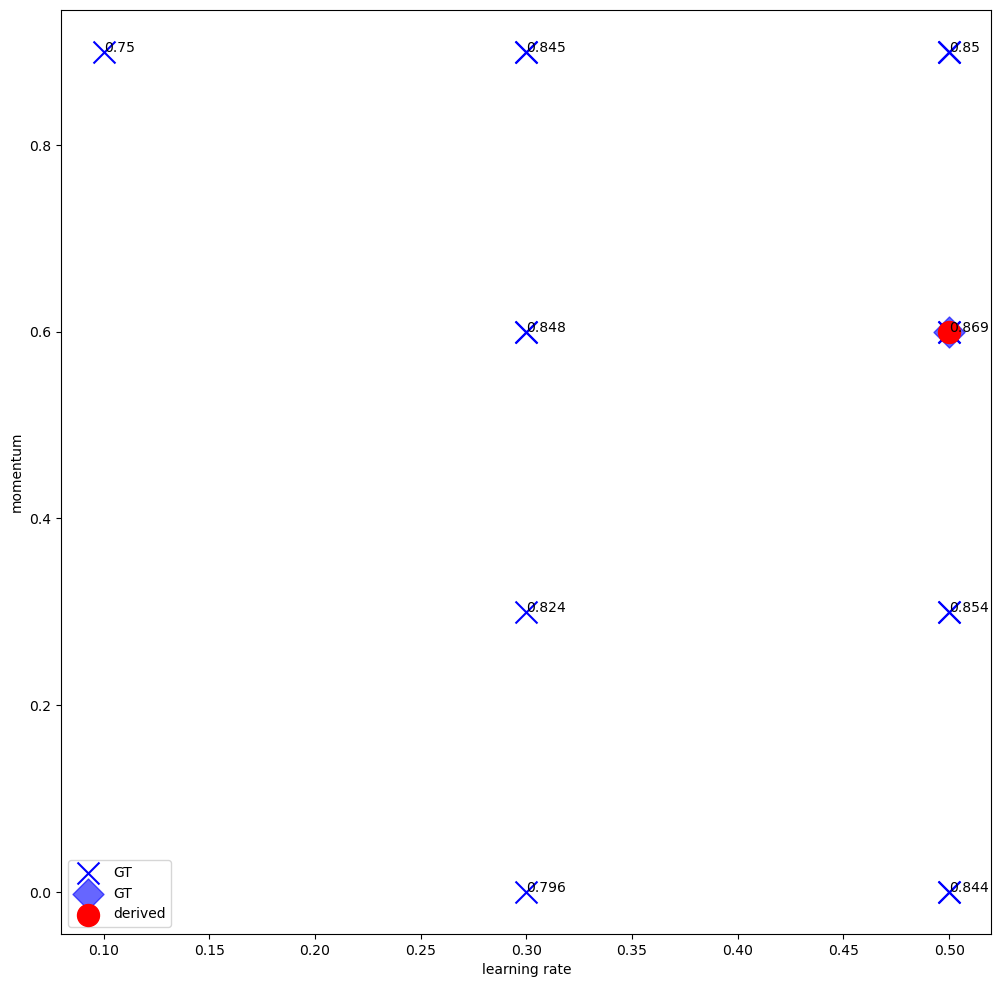

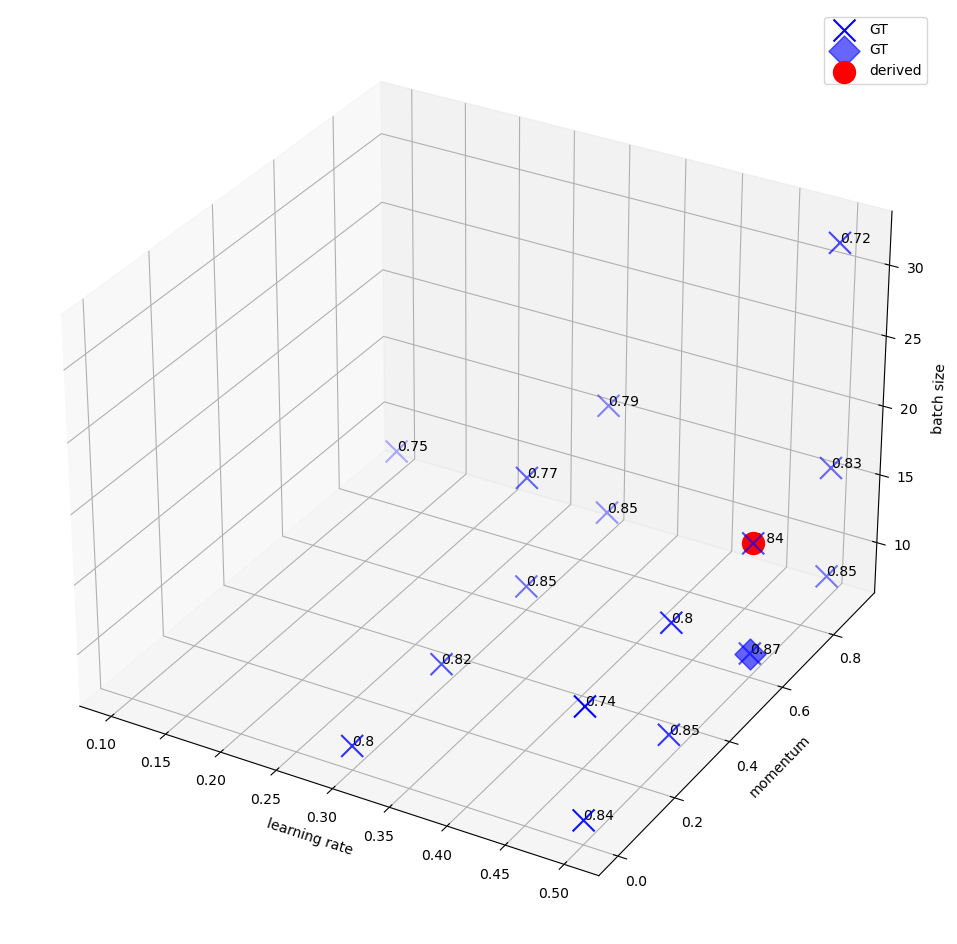

In [26]:
dataset_name = svhn_datasets[1]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

##### 0.1 skew

In 2d: [{'lr_mom_bs': (0.5, 0.29999999999999993, 16), 'closest_lr_mom_bs_acc': (0.5, 0.3, 16.0, 0.8554471)}, {'lr_mom_bs': (0.07309090909090905, 0.9299999999999999, 16), 'closest_lr_mom_bs_acc': (0.05, 0.9, 16.0, 0.5585433)}, {'lr_mom_bs': (0.5, 0.5999999999999999, 32), 'closest_lr_mom_bs_acc': (0.5, 0.6, 32.0, 0.83800703)}]
In 3d: [{'lr_mom_bs': (0.5, 0.3, 16), 'closest_lr_mom_bs_acc': (0.5, 0.3, 16.0, 0.8554471)}, {'lr_mom_bs': (0.5, 0.6, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.8650507)}, {'lr_mom_bs': (0.08631578947368423, 0.9447368421052628, 32), 'closest_lr_mom_bs_acc': (0.1, 0.9, 32.0, 0.40100646)}]


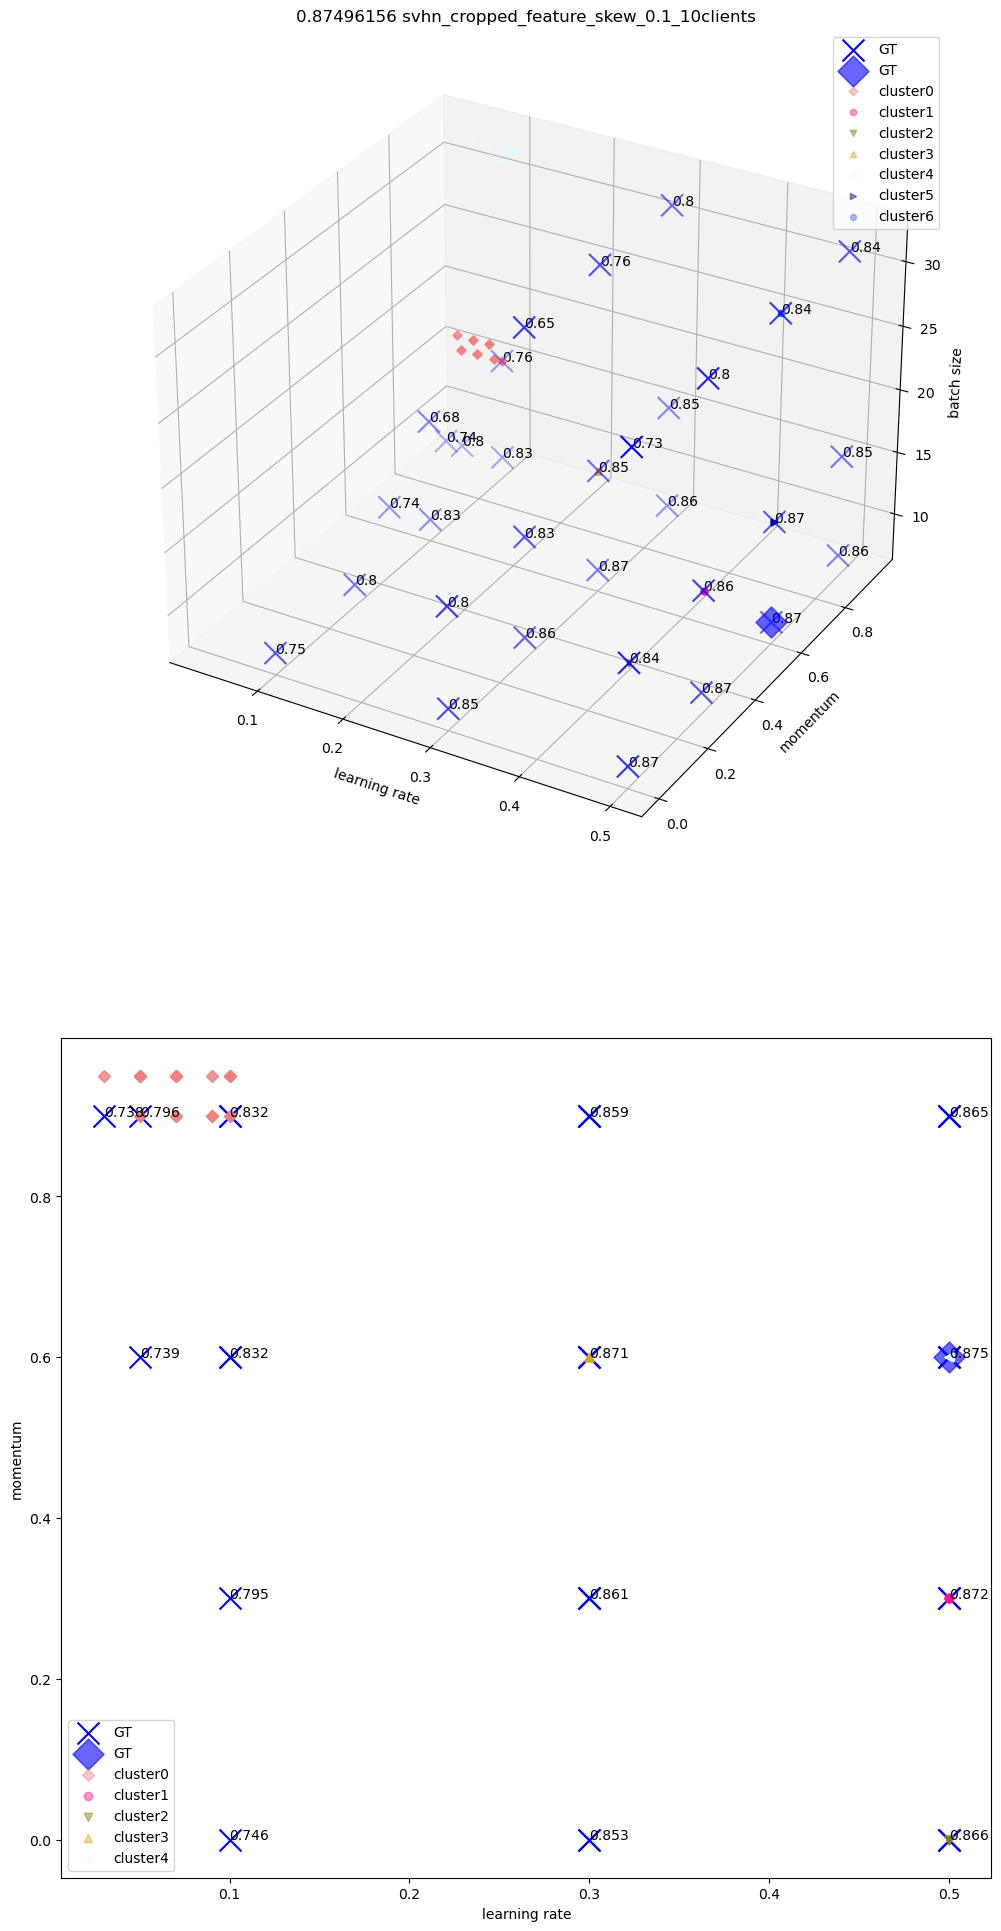

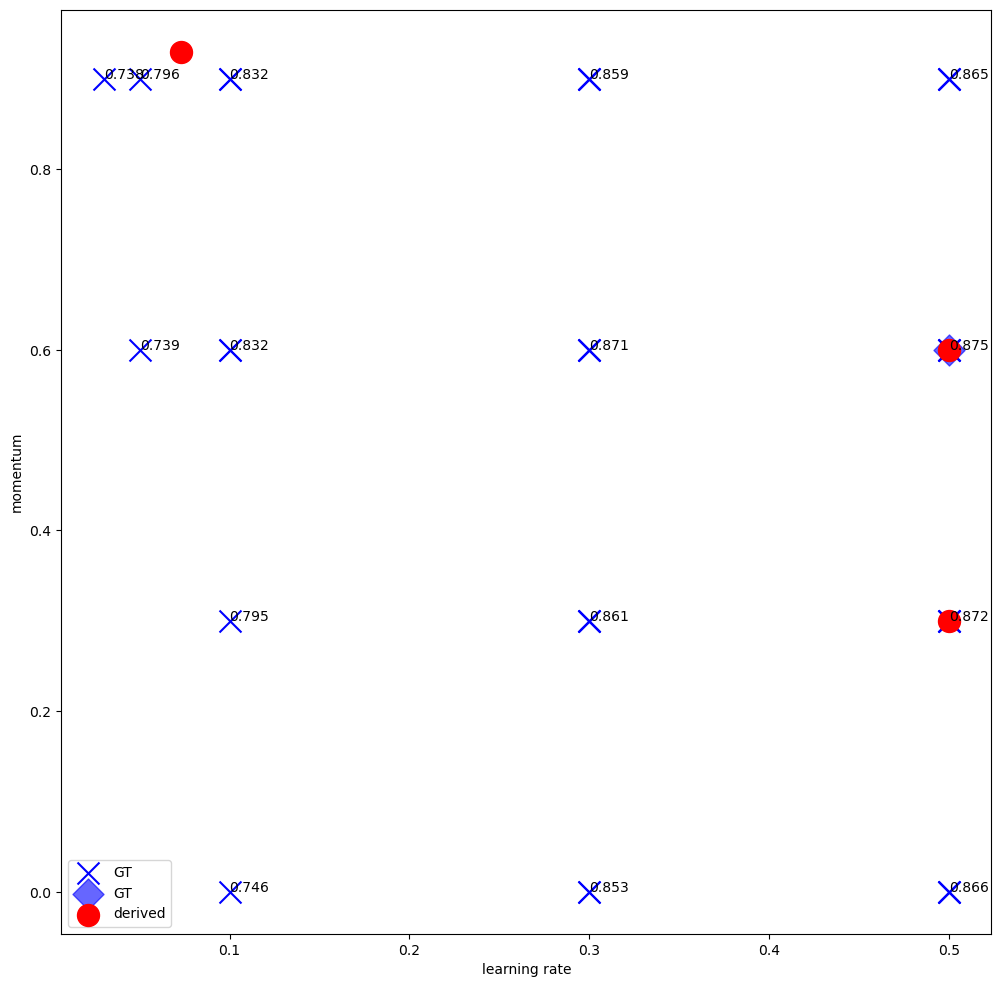

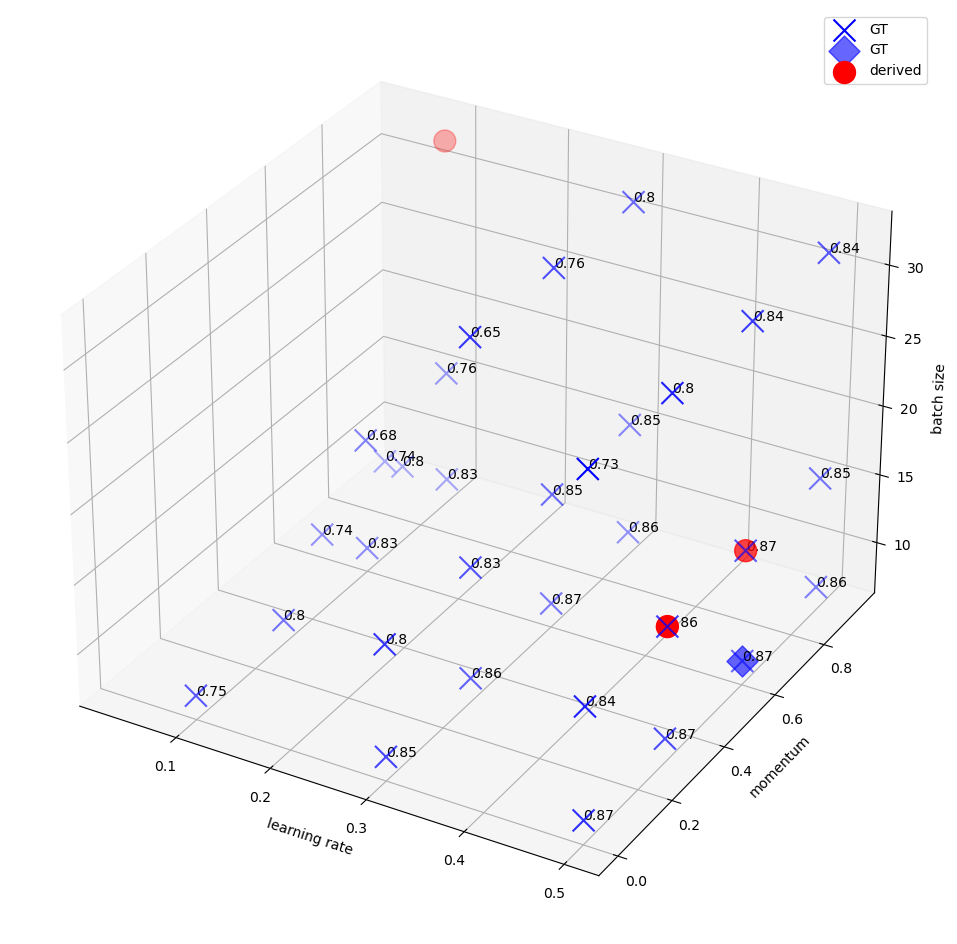

In [27]:
dataset_name = svhn_datasets[2]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

In 2d: [{'lr_mom_bs': (0.5, 0.5999999999999998, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.8339735)}, {'lr_mom_bs': (0.29999999999999993, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.3, 0.6, 16.0, 0.75176704)}, {'lr_mom_bs': (0.07871212121212115, 0.9318181818181839, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.3292486)}]
In 3d: [{'lr_mom_bs': (0.5, 0.5999999999999999, 16), 'closest_lr_mom_bs_acc': (0.5, 0.6, 16.0, 0.8339735)}, {'lr_mom_bs': (0.07681415929203532, 0.9287610619469046, 16), 'closest_lr_mom_bs_acc': (0.1, 0.9, 16.0, 0.3292486)}, {'lr_mom_bs': (0.29999999999999993, 0.9000000000000001, 32), 'closest_lr_mom_bs_acc': (0.3, 0.9, 32.0, 0.3729256)}]


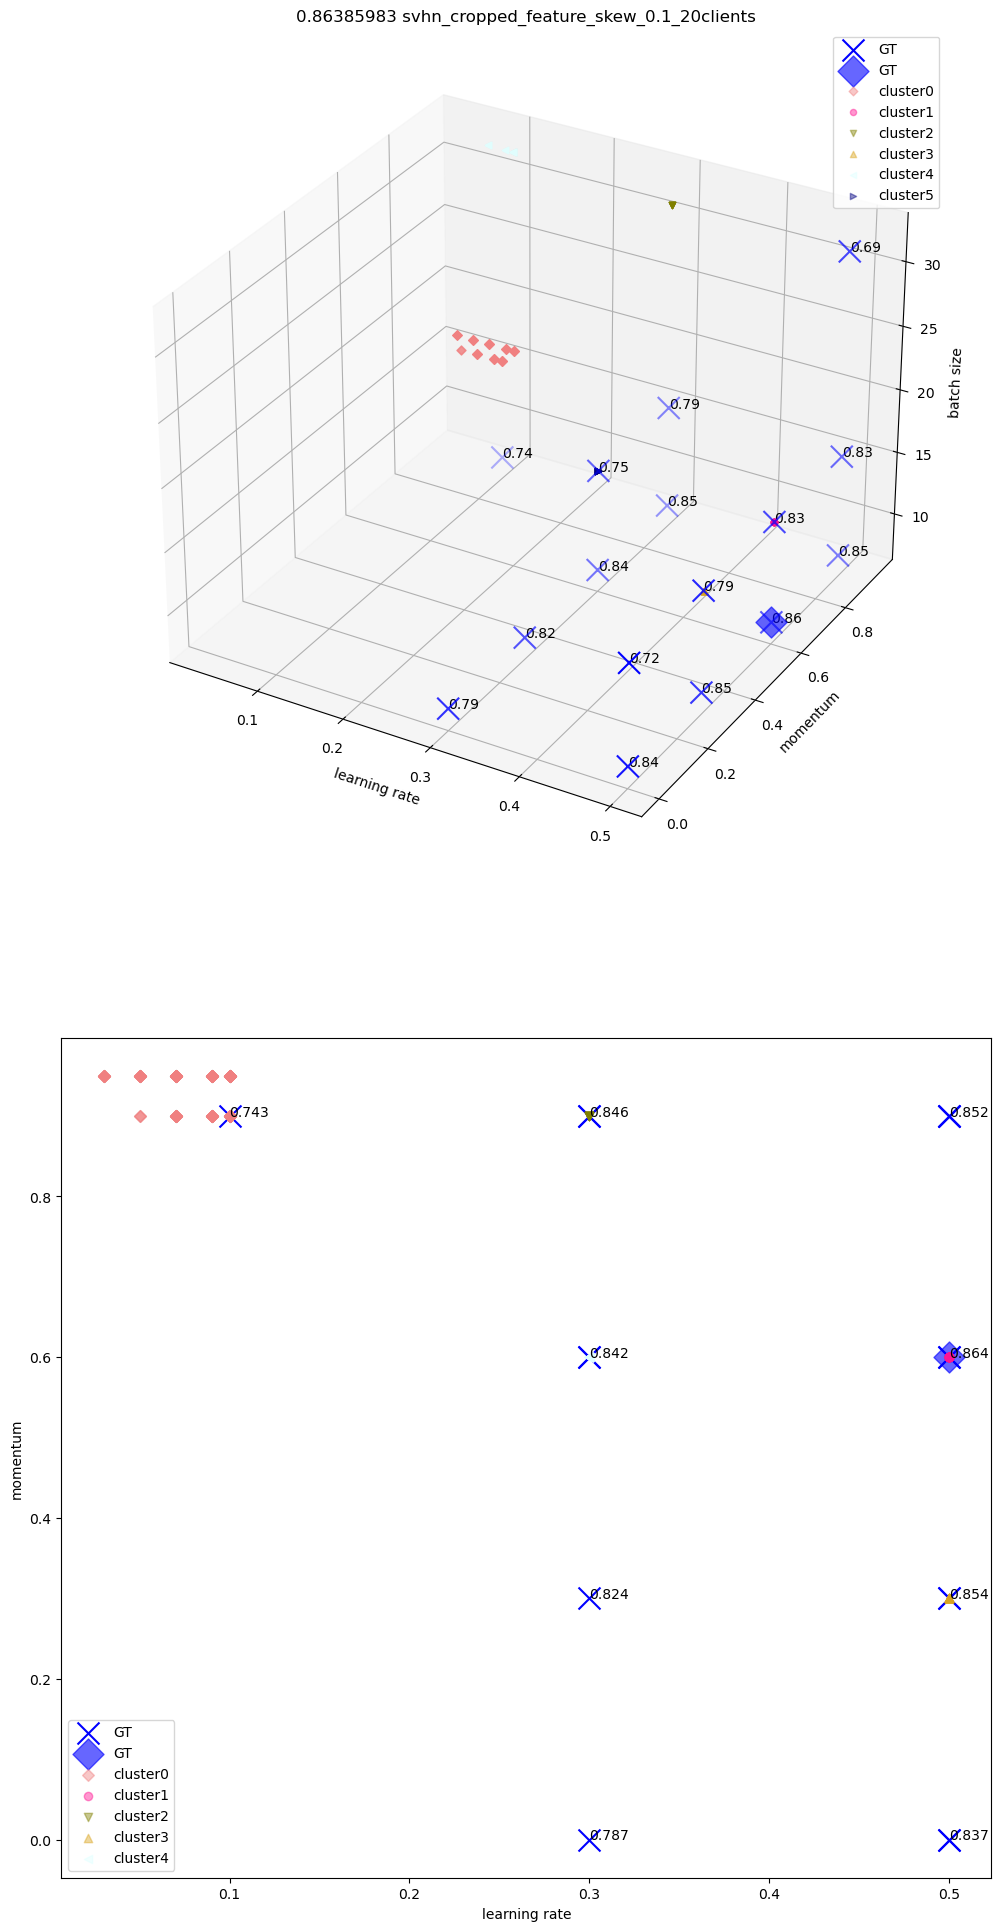

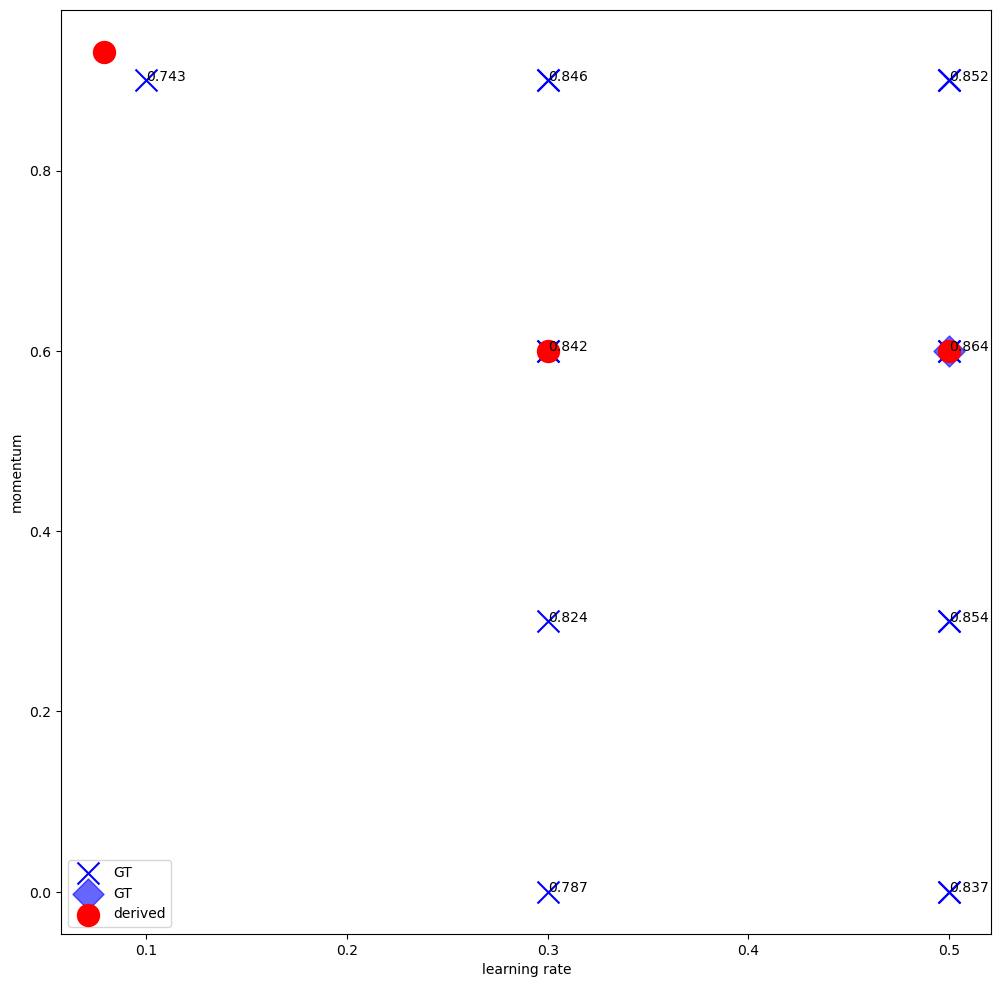

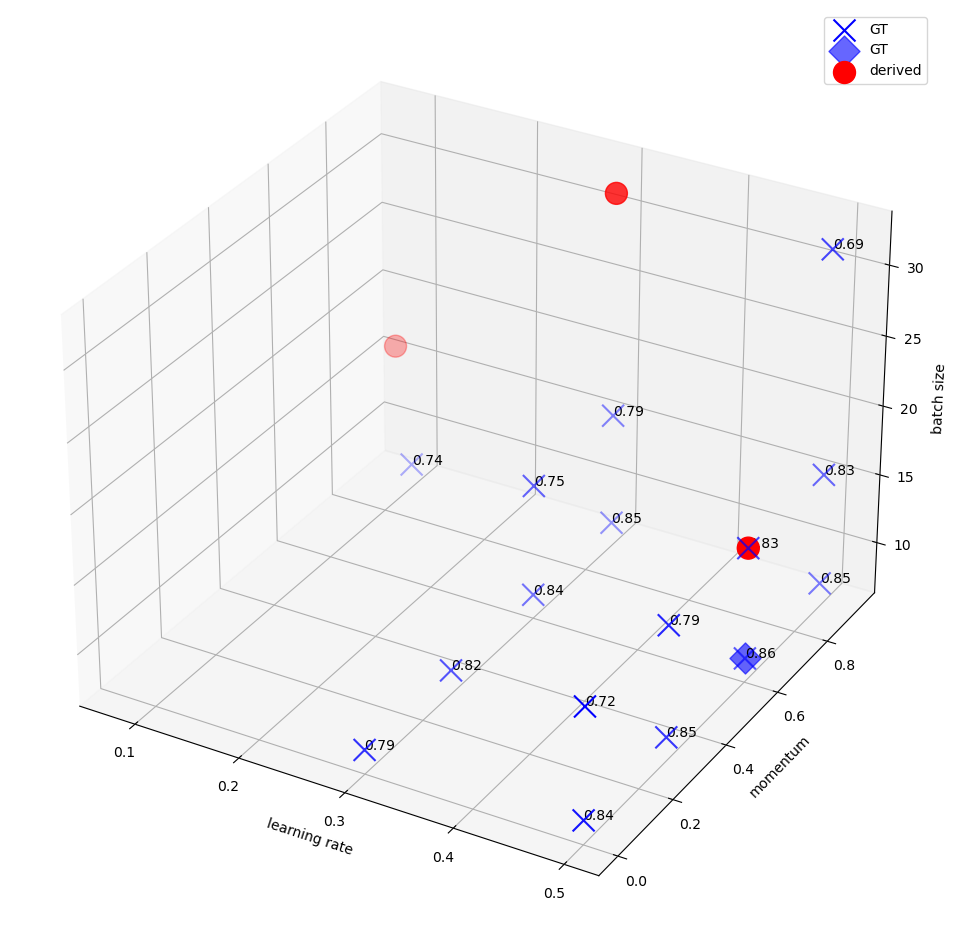

In [28]:
dataset_name = svhn_datasets[3]

serverData, clientData, clusterFn, clusterFn_3d = clustering(dataset_name, useDbscan=True, shouldPrint=False, drawFig=True, saveFig=False)
derived_hps_2d, derived_hps_2d_pd = derive_global_hp(clusterFn, clientData, dataset_name)
derived_hps_3d, derived_hps_3d_pd = derive_global_hp(clusterFn_3d, clientData, dataset_name)

print("In 2d:", derived_hps_2d)
print("In 3d:", derived_hps_3d)
plot_points_agains_gt_2d(serverData, derived_hps_2d_pd)
plot_points_agains_gt_3d(serverData, derived_hps_3d_pd)

### Conclusions:

1. No client thinks BatchSize=8 is good.
2. When looking in 2D (learning rate, momentum) good/best HPs are found (when neglecting BS)
3. Clients usually go for lower learning rate -> gt has larger learning rate.
4. 2D clustering gives better results for SVHN_cropped (not that better results for other datasets when using 3d clustering)
5. Selecting multiple best mean-acc clusters is not (always) needed -> usually the absolute best cluster is the one we need.